In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
# data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
# data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

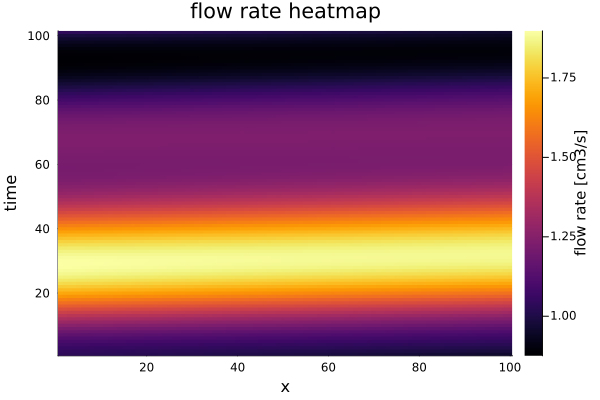

In [5]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


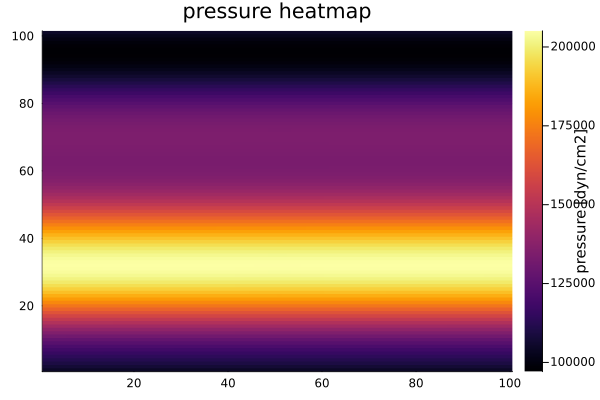

In [6]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [15]:
begin
    global dt = 0.01                     # time step
    global T = 1.0                   # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem
    global L = 4.0                       # total length of 1d sim
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [16]:
#waveforms to use
waveforms = 5

5

In [17]:
# select number of points in x to use

In [18]:
u0 = data1d_fix[1,1:2:end,1:waveforms,1];
u01 = data1d_fix[1,1:2:end,1,1];

In [19]:
ytrain2 = data1d_fix[:,1:2:end,1:waveforms,1];
ytrain21 = data1d_fix[:,1:2:end,1,1];


In [20]:
bc_flow = data1d_fix[:,1,:,1];
bc_flow1 = bc_flow[:,1];

In [21]:
size(ytrain21)

(101, 50)

In [22]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");
# finite-difference schemes


N = size(u01,1)
dx = L/N                      # spatial step
x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
#first order derivatives
∂x1_center = f1_secondOrder_central(N,dx);
∂x1_forward = f1_secondOrder_forward(N,dx);
∂x1_backward = f1_secondOrder_backward(N,dx);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(N,dx);
∂x2_forward = f2_secondOrder_forward(N,dx);
∂x2_backward = f2_secondOrder_backward(N,dx);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

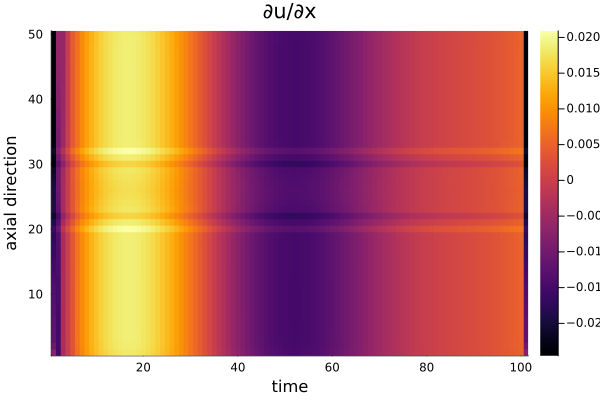

In [31]:
heatmap(∂x1 * ytrain2[:,:,1]')
title!("∂u/∂x")
xlabel!("time")
ylabel!("axial direction")

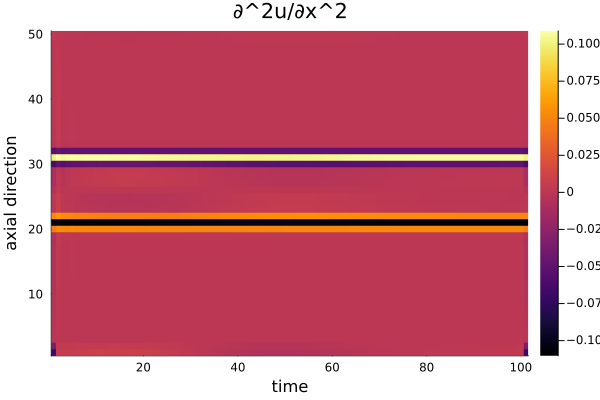

In [32]:
heatmap(∂x2 * ytrain2[:,:,1]')
title!("∂^2u/∂x^2")
xlabel!("time")
ylabel!("axial direction")

In [33]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N + size(bc_flow1)[1], hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(151 => 10, tanh),               # 1_520 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 50),                      # 550 parameters
)                   # Total: 8 arrays, 2_290 parameters, 9.445 KiB.

In [34]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2290


In [35]:
# function learn_1DBlood(u, p, t, bc_left)
#     Φ = re(p) # restructure flattened parameter vector into NN architecture.
#     # Apply boundary conditions
#     u[1] = bc_left(t)
#     return Φ(u)
# end



function learn_1DBlood(u, p, t, bc_left)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    #concatenate u and the BC as input to the NN
    input = vcat(u,bc_left)
    
    return Φ(input)  # Call Φ with modified input
end



learn_1DBlood (generic function with 1 method)

In [36]:
# Define time-dependent boundary conditions
function bc_left(t, bc_flow1)
    # Define the value of the boundary condition at the left boundary for a given time t

    # Find the two closest points in bc_flow1
    #caculate the time index that's closest to time t
    t_index = Int(floor(t / dt)) + 1
    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        bc_interp = bc_flow1[t_index]
        
    else
        bc_interp = (1 - t_frac) * bc_flow1[t_index] + t_frac * bc_flow1[t_index + 1]
    end
    
    return bc_interp
end


# Define time-dependent boundary condition function
bc_left_func(t) = bc_left(t, bc_flow1)

bc_left_func (generic function with 1 method)

In [37]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p)


learn_1DBlood_prob (generic function with 1 method)

In [38]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/paramBC_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(151 => 10, tanh)  # 1_520 parameters
│   summary(x) = "151-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


saved untrained solution


In [39]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
end 

predict (generic function with 1 method)

In [61]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    # add du/dx in the loss function
    l = sum(abs2,(pred[:,:] - ytrain21))+ 1e-1*sum(abs2,∂x1 * pred - ∂x1 * ytrain21) + 1e-3*sum(abs2,∂x2 * pred - ∂x2 * ytrain21) #  + 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [62]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "ADAM"

"ADAM"

In [63]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [64]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is ADAM optimizer
ODE Time integrator selected:Tsit5


In [65]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


nt:100
Start training epoch 1
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-10.52714
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 14954.567039857702
Iteration: 2 || Loss: 14294.708580923507
Iteration: 3 || Loss: 13651.057667900943
Iteration: 4 || Loss: 13026.10669502796
Iteration: 5 || Loss: 12422.235539617472
Iteration: 6 || Loss: 12422.235539617472
saving ADAM checkpoint...
Sum of params:-10.413219
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12422.235539617472
Iteration: 2 || Loss: 11837.773960235183
Iteration: 3 || Loss: 11277.999504356827
Iteration: 4 || Loss: 10744.304332753498
Iteration: 5 || Loss: 10237.721068788373
Iteration: 6 || Loss: 9759.368009831294
Iteration: 7 || Loss: 9309.929265989698
Iteration: 8 || Loss: 8889.443119070585
Iteration: 9 || Loss: 8497.132529304403
Iteration: 10 || Loss: 8131.382061066837
Iteration: 11 || Loss: 7789.835672767753
Iteration: 12 || Loss: 7469.581574133507
It

Iteration: 186 || Loss: 394.25423534367116
Iteration: 187 || Loss: 394.02792299662974
Iteration: 188 || Loss: 393.8070237687046
Iteration: 189 || Loss: 393.5913771176598
Iteration: 190 || Loss: 393.38091987532835
Iteration: 191 || Loss: 393.17554990271805
Iteration: 192 || Loss: 392.97499041734557
Iteration: 193 || Loss: 392.77929581666336
Iteration: 194 || Loss: 392.5883633864972
Iteration: 195 || Loss: 392.4020191929733
Iteration: 196 || Loss: 392.2202228085727
Iteration: 197 || Loss: 392.0427602647977
Iteration: 198 || Loss: 391.8696438566902
Iteration: 199 || Loss: 391.70081771201967
Iteration: 200 || Loss: 391.5360027997816
Iteration: 201 || Loss: 391.3752532513863
Iteration: 202 || Loss: 391.2185015912775
Iteration: 203 || Loss: 391.06550212652184
Iteration: 204 || Loss: 390.9162713483648
Iteration: 205 || Loss: 390.77071591441205
Iteration: 206 || Loss: 390.6287061204794
Iteration: 207 || Loss: 390.4902059595701
Iteration: 208 || Loss: 390.35510713747357
Iteration: 209 || Loss: 

Iteration: 380 || Loss: 384.3708838643663
Iteration: 381 || Loss: 384.3613841750102
Iteration: 382 || Loss: 384.3519709874589
Iteration: 383 || Loss: 384.34257838813187
Iteration: 384 || Loss: 384.33321792754066
Iteration: 385 || Loss: 384.32392611539063
Iteration: 386 || Loss: 384.3146489999456
Iteration: 387 || Loss: 384.3054430062542
Iteration: 388 || Loss: 384.29625891256984
Iteration: 389 || Loss: 384.2871416191123
Iteration: 390 || Loss: 384.2780671020577
Iteration: 391 || Loss: 384.269016357967
Iteration: 392 || Loss: 384.25999838168667
Iteration: 393 || Loss: 384.2510339386464
Iteration: 394 || Loss: 384.24213766197454
Iteration: 395 || Loss: 384.2332467842449
Iteration: 396 || Loss: 384.22441485683777
Iteration: 397 || Loss: 384.21562855896497
Iteration: 398 || Loss: 384.2068715964445
Iteration: 399 || Loss: 384.1981368304667
Iteration: 400 || Loss: 384.18948491356895
Iteration: 401 || Loss: 384.18083155439734
Iteration: 402 || Loss: 384.1722319868605
Iteration: 403 || Loss: 3

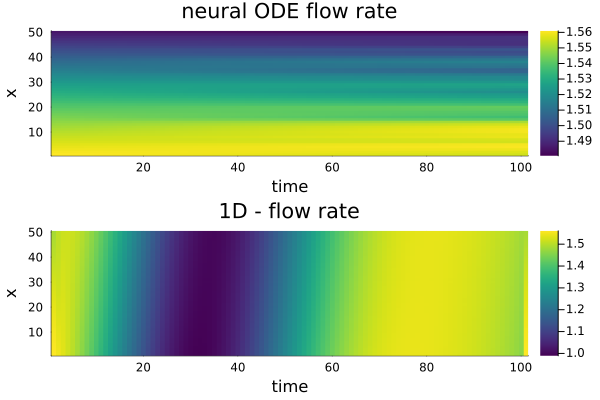

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-6.673049
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 559.9645644908796
Iteration: 2 || Loss: 448.3037032215342
Iteration: 3 || Loss: 417.7427478149582
Iteration: 4 || Loss: 438.1483987017667
Iteration: 5 || Loss: 459.78227685801465
Iteration: 6 || Loss: 417.7427478149582
saving ADAM checkpoint...
Sum of params:-6.555486
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 417.7427478149582
Iteration: 2 || Loss: 425.8254942750167
Iteration: 3 || Loss: 415.4931905708964
Iteration: 4 || Loss: 421.0582382397099
Iteration: 5 || Loss: 416.50882990084506
Iteration: 6 || Loss: 411.4470894486286
Iteration: 7 || Loss: 413.56325411120304
Iteration: 8 || Loss: 416.0799874180731
Iteration: 9 || Loss: 414.4362403087269
Iteration: 10 || Loss: 412.4324444175092
Iteration: 11 || Loss: 412.81456033417896
Iteration: 12 || Loss: 413.4067204530299
Iteration: 13 || Loss: 412.2785381543754
Iteratio

Iteration: 187 || Loss: 403.5088510977337
Iteration: 188 || Loss: 403.4607897804961
Iteration: 189 || Loss: 403.4126041881344
Iteration: 190 || Loss: 403.3643529377113
Iteration: 191 || Loss: 403.315999840334
Iteration: 192 || Loss: 403.26752373640596
Iteration: 193 || Loss: 403.2190102992898
Iteration: 194 || Loss: 403.1703533191815
Iteration: 195 || Loss: 403.1216162577394
Iteration: 196 || Loss: 403.0727573372193
Iteration: 197 || Loss: 403.02385649093287
Iteration: 198 || Loss: 402.9748135785119
Iteration: 199 || Loss: 402.92568842818054
Iteration: 200 || Loss: 402.8764552336946
Iteration: 201 || Loss: 402.82715325511094
Iteration: 202 || Loss: 402.7776892207343
Iteration: 203 || Loss: 402.728199552337
Iteration: 204 || Loss: 402.67855496183864
Iteration: 205 || Loss: 402.62883648183424
Iteration: 206 || Loss: 402.57901270252387
Iteration: 207 || Loss: 402.52907993522723
Iteration: 208 || Loss: 402.47903583259955
Iteration: 209 || Loss: 402.42893664245565
Iteration: 210 || Loss: 40

Iteration: 381 || Loss: 391.53167576871493
Iteration: 382 || Loss: 391.44754186112266
Iteration: 383 || Loss: 391.3630745411345
Iteration: 384 || Loss: 391.278205815159
Iteration: 385 || Loss: 391.192960666766
Iteration: 386 || Loss: 391.10734299577575
Iteration: 387 || Loss: 391.02132290581653
Iteration: 388 || Loss: 390.9349173834966
Iteration: 389 || Loss: 390.8480991553723
Iteration: 390 || Loss: 390.7608978921787
Iteration: 391 || Loss: 390.67331217492523
Iteration: 392 || Loss: 390.58534156826795
Iteration: 393 || Loss: 390.4969327838333
Iteration: 394 || Loss: 390.4081097584907
Iteration: 395 || Loss: 390.3189093632672
Iteration: 396 || Loss: 390.2292409223754
Iteration: 397 || Loss: 390.13915103355805
Iteration: 398 || Loss: 390.04871909259515
Iteration: 399 || Loss: 389.9577153598349
Iteration: 400 || Loss: 389.86635507910455
Iteration: 401 || Loss: 389.7745283158371
Iteration: 402 || Loss: 389.6823347952561
Iteration: 403 || Loss: 389.58961051107485
Iteration: 404 || Loss: 38

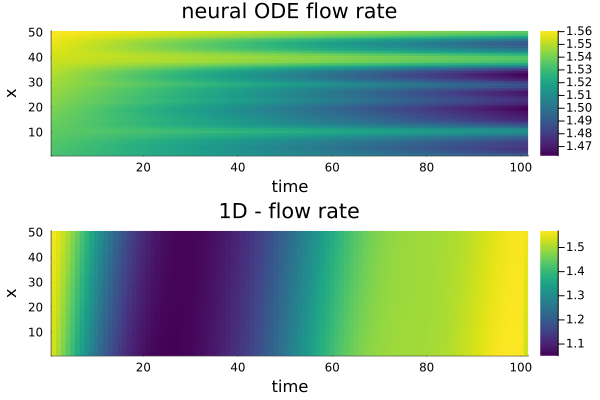

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-4.199527
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 656.1056886186917
Iteration: 2 || Loss: 543.4545855489552
Iteration: 3 || Loss: 502.3699792717545
Iteration: 4 || Loss: 512.4019297016324
Iteration: 5 || Loss: 534.7576284475107
Iteration: 6 || Loss: 502.3699792717545
saving ADAM checkpoint...
Sum of params:-4.2608395
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 502.3699792717545
Iteration: 2 || Loss: 503.12045822776037
Iteration: 3 || Loss: 496.21704104887334
Iteration: 4 || Loss: 492.9876087186859
Iteration: 5 || Loss: 495.6171430614559
Iteration: 6 || Loss: 496.11360606610623
Iteration: 7 || Loss: 493.71620558581725
Iteration: 8 || Loss: 491.3835252285643
Iteration: 9 || Loss: 490.6991818397138
Iteration: 10 || Loss: 491.4481618899991
Iteration: 11 || Loss: 491.9532627125235
Iteration: 12 || Loss: 491.68798651723057
Iteration: 13 || Loss: 491.4203099936714
Iterat

Iteration: 186 || Loss: 461.25651211153047
Iteration: 187 || Loss: 461.0313773203686
Iteration: 188 || Loss: 460.80553325058224
Iteration: 189 || Loss: 460.5791165140342
Iteration: 190 || Loss: 460.35202234930296
Iteration: 191 || Loss: 460.12437687967764
Iteration: 192 || Loss: 459.895989172219
Iteration: 193 || Loss: 459.66700547009407
Iteration: 194 || Loss: 459.43735181650374
Iteration: 195 || Loss: 459.20717932661734
Iteration: 196 || Loss: 458.97628713371324
Iteration: 197 || Loss: 458.7448046787747
Iteration: 198 || Loss: 458.51276390085724
Iteration: 199 || Loss: 458.2799769233643
Iteration: 200 || Loss: 458.0467442413597
Iteration: 201 || Loss: 457.81270042938706
Iteration: 202 || Loss: 457.57820057086315
Iteration: 203 || Loss: 457.3430963175536
Iteration: 204 || Loss: 457.10737212037503
Iteration: 205 || Loss: 456.8710835988037
Iteration: 206 || Loss: 456.6342372430711
Iteration: 207 || Loss: 456.3967670350198
Iteration: 208 || Loss: 456.1586804353119
Iteration: 209 || Loss:

Iteration: 380 || Loss: 416.57497348134336
Iteration: 381 || Loss: 416.3915067493712
Iteration: 382 || Loss: 416.23829242276577
Iteration: 383 || Loss: 416.09080358637794
Iteration: 384 || Loss: 415.92675211233586
Iteration: 385 || Loss: 415.7369086852787
Iteration: 386 || Loss: 415.5345759881501
Iteration: 387 || Loss: 415.3405390220938
Iteration: 388 || Loss: 415.1676245386219
Iteration: 389 || Loss: 415.01135561763846
Iteration: 390 || Loss: 414.85707780168536
Iteration: 391 || Loss: 414.69291091030686
Iteration: 392 || Loss: 414.5160156801585
Iteration: 393 || Loss: 414.33475999419704
Iteration: 394 || Loss: 414.1593926450296
Iteration: 395 || Loss: 413.9950539458588
Iteration: 396 || Loss: 413.83932144809677
Iteration: 397 || Loss: 413.6850339921558
Iteration: 398 || Loss: 413.5267247273863
Iteration: 399 || Loss: 413.3628069246703
Iteration: 400 || Loss: 413.19663301674984
Iteration: 401 || Loss: 413.0323950185443
Iteration: 402 || Loss: 412.8732646018003
Iteration: 403 || Loss: 

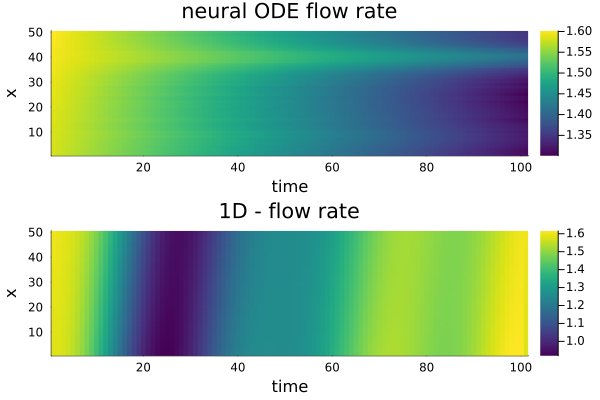

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-4.35446
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 397.4762041382763
Iteration: 2 || Loss: 381.6257822330506
Iteration: 3 || Loss: 380.32747834196346
Iteration: 4 || Loss: 378.39861172777455
Iteration: 5 || Loss: 380.4578776226969
Iteration: 6 || Loss: 378.39861172777455
saving ADAM checkpoint...
Sum of params:-4.3975525
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 378.39861172777455
Iteration: 2 || Loss: 387.4290984498557
Iteration: 3 || Loss: 375.0844456011699
Iteration: 4 || Loss: 380.4755604679565
Iteration: 5 || Loss: 381.17503271494525
Iteration: 6 || Loss: 375.37779773377724
Iteration: 7 || Loss: 373.57637549528664
Iteration: 8 || Loss: 376.80117299945573
Iteration: 9 || Loss: 378.2147598324793
Iteration: 10 || Loss: 376.0558361323678
Iteration: 11 || Loss: 374.03142145438125
Iteration: 12 || Loss: 374.3800575765139
Iteration: 13 || Loss: 375.43931555578143
It

Iteration: 186 || Loss: 371.2704221993354
Iteration: 187 || Loss: 371.2606455139176
Iteration: 188 || Loss: 371.2508141261939
Iteration: 189 || Loss: 371.24108838990253
Iteration: 190 || Loss: 371.23141877336053
Iteration: 191 || Loss: 371.2217516291864
Iteration: 192 || Loss: 371.212139706362
Iteration: 193 || Loss: 371.20245066689324
Iteration: 194 || Loss: 371.19286040869696
Iteration: 195 || Loss: 371.18326291449597
Iteration: 196 || Loss: 371.17374737157024
Iteration: 197 || Loss: 371.164230757719
Iteration: 198 || Loss: 371.1547545300839
Iteration: 199 || Loss: 371.1452623422282
Iteration: 200 || Loss: 371.1358659273552
Iteration: 201 || Loss: 371.1264568906623
Iteration: 202 || Loss: 371.11712043670167
Iteration: 203 || Loss: 371.107731436247
Iteration: 204 || Loss: 371.09846886003237
Iteration: 205 || Loss: 371.0891566902348
Iteration: 206 || Loss: 371.0799331646763
Iteration: 207 || Loss: 371.07065322896165
Iteration: 208 || Loss: 371.061482614704
Iteration: 209 || Loss: 371.0

Iteration: 380 || Loss: 369.8526353055078
Iteration: 381 || Loss: 369.8472937197055
Iteration: 382 || Loss: 369.8419844868805
Iteration: 383 || Loss: 369.83675622162673
Iteration: 384 || Loss: 369.8314874351183
Iteration: 385 || Loss: 369.82628048301325
Iteration: 386 || Loss: 369.82100676140124
Iteration: 387 || Loss: 369.8158116886175
Iteration: 388 || Loss: 369.8105806222301
Iteration: 389 || Loss: 369.8053664672791
Iteration: 390 || Loss: 369.80022160200053
Iteration: 391 || Loss: 369.79503501619956
Iteration: 392 || Loss: 369.78991204657484
Iteration: 393 || Loss: 369.78473027853556
Iteration: 394 || Loss: 369.7796341374294
Iteration: 395 || Loss: 369.77447067694845
Iteration: 396 || Loss: 369.7693722330524
Iteration: 397 || Loss: 369.7643035467565
Iteration: 398 || Loss: 369.7592019923157
Iteration: 399 || Loss: 369.75416267303507
Iteration: 400 || Loss: 369.74909937912156
Iteration: 401 || Loss: 369.7440301802638
Iteration: 402 || Loss: 369.73906403154933
Iteration: 403 || Loss:

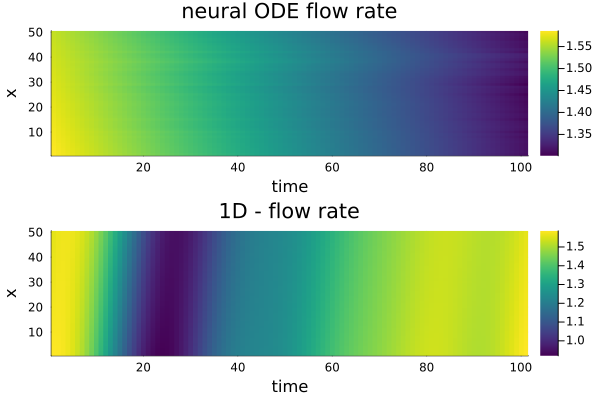

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-3.3069966
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 503.6189889978224
Iteration: 2 || Loss: 487.9115259695424
Iteration: 3 || Loss: 474.53349790648025
Iteration: 4 || Loss: 463.75311292209057
Iteration: 5 || Loss: 461.01130657233745
Iteration: 6 || Loss: 461.01130657233745
saving ADAM checkpoint...
Sum of params:-3.2168677
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 461.01130657233745
Iteration: 2 || Loss: 470.99740217224235
Iteration: 3 || Loss: 459.76809955920373
Iteration: 4 || Loss: 465.74682170910444
Iteration: 5 || Loss: 463.6441212813494
Iteration: 6 || Loss: 459.4150154547378
Iteration: 7 || Loss: 460.809123857487
Iteration: 8 || Loss: 462.6737465907316
Iteration: 9 || Loss: 460.6992941403611
Iteration: 10 || Loss: 458.3286453684863
Iteration: 11 || Loss: 458.7915853242842
Iteration: 12 || Loss: 460.4026586574905
Iteration: 13 || Loss: 460.16452406388714
It

Iteration: 186 || Loss: 446.0155475348185
Iteration: 187 || Loss: 445.9846339218775
Iteration: 188 || Loss: 445.9538846206098
Iteration: 189 || Loss: 445.9233541388502
Iteration: 190 || Loss: 445.89298325334283
Iteration: 191 || Loss: 445.862713820934
Iteration: 192 || Loss: 445.83269225280753
Iteration: 193 || Loss: 445.80271605147556
Iteration: 194 || Loss: 445.7729434644221
Iteration: 195 || Loss: 445.74329543924813
Iteration: 196 || Loss: 445.7137334193112
Iteration: 197 || Loss: 445.68435431317283
Iteration: 198 || Loss: 445.6551199809462
Iteration: 199 || Loss: 445.62601644428986
Iteration: 200 || Loss: 445.59702155329103
Iteration: 201 || Loss: 445.5681622470268
Iteration: 202 || Loss: 445.53942767343835
Iteration: 203 || Loss: 445.51085677232834
Iteration: 204 || Loss: 445.482350636428
Iteration: 205 || Loss: 445.45402223632607
Iteration: 206 || Loss: 445.42579519375573
Iteration: 207 || Loss: 445.3976762952213
Iteration: 208 || Loss: 445.3697340651315
Iteration: 209 || Loss: 4

Iteration: 380 || Loss: 443.0859996429154
Iteration: 381 || Loss: 443.0776863744558
Iteration: 382 || Loss: 443.06993711335235
Iteration: 383 || Loss: 443.06228623255276
Iteration: 384 || Loss: 443.05426024134005
Iteration: 385 || Loss: 443.0459739783285
Iteration: 386 || Loss: 443.03765290893944
Iteration: 387 || Loss: 443.02969996383797
Iteration: 388 || Loss: 443.0218507415497
Iteration: 389 || Loss: 443.01391641489806
Iteration: 390 || Loss: 443.00574706403665
Iteration: 391 || Loss: 442.9975321829477
Iteration: 392 || Loss: 442.98930925569806
Iteration: 393 || Loss: 442.9812745211881
Iteration: 394 || Loss: 442.97326551526675
Iteration: 395 || Loss: 442.96525201355945
Iteration: 396 || Loss: 442.9570886422511
Iteration: 397 || Loss: 442.94886096358164
Iteration: 398 || Loss: 442.9406325319905
Iteration: 399 || Loss: 442.9323941631801
Iteration: 400 || Loss: 442.9242730820849
Iteration: 401 || Loss: 442.91610124360557
Iteration: 402 || Loss: 442.9079481995887
Iteration: 403 || Loss

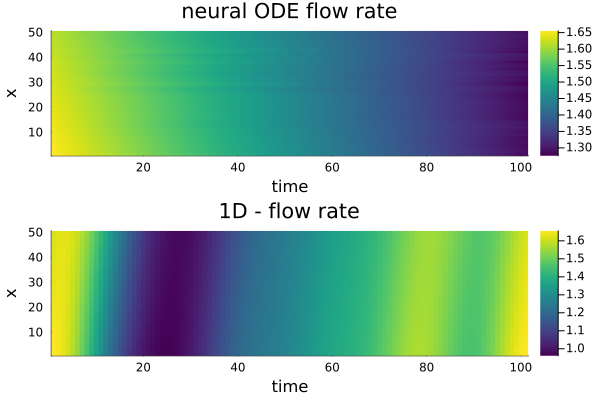

Epoch 1 mean loss loss:394.9972505681114
Start training epoch 2
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-4.7026906
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 366.9000112245205
Iteration: 2 || Loss: 358.84874901057486
Iteration: 3 || Loss: 356.7587832011374
Iteration: 4 || Loss: 352.0663842847623
Iteration: 5 || Loss: 352.84552629697555
Iteration: 6 || Loss: 352.0663842847623
saving ADAM checkpoint...
Sum of params:-4.613578
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 352.0663842847623
Iteration: 2 || Loss: 359.858045400745
Iteration: 3 || Loss: 353.21543217884835
Iteration: 4 || Loss: 353.90075376529273
Iteration: 5 || Loss: 351.8432218673353
Iteration: 6 || Loss: 351.20196878604924
Iteration: 7 || Loss: 352.1178925292154
Iteration: 8 || Loss: 350.936142148267
Iteration: 9 || Loss: 348.93748472010515
Iteration: 10 || Loss: 348.7639565445325
Iteration: 11 || Loss: 

Iteration: 184 || Loss: 314.64252972796925
Iteration: 185 || Loss: 314.633325831829
Iteration: 186 || Loss: 314.62183394941263
Iteration: 187 || Loss: 314.60929067236395
Iteration: 188 || Loss: 314.5989607432621
Iteration: 189 || Loss: 314.5894317266173
Iteration: 190 || Loss: 314.5785211589495
Iteration: 191 || Loss: 314.56682864492427
Iteration: 192 || Loss: 314.55628114452946
Iteration: 193 || Loss: 314.5467081001293
Iteration: 194 || Loss: 314.5363167760853
Iteration: 195 || Loss: 314.5251459087699
Iteration: 196 || Loss: 314.51460497494685
Iteration: 197 || Loss: 314.5047445134252
Iteration: 198 || Loss: 314.49474272495615
Iteration: 199 || Loss: 314.48411983394806
Iteration: 200 || Loss: 314.4735319217802
Iteration: 201 || Loss: 314.4634015266817
Iteration: 202 || Loss: 314.453522291585
Iteration: 203 || Loss: 314.4433560045803
Iteration: 204 || Loss: 314.4329482285743
Iteration: 205 || Loss: 314.42268555660974
Iteration: 206 || Loss: 314.4127139352643
Iteration: 207 || Loss: 314

Iteration: 378 || Loss: 312.58448363908417
Iteration: 379 || Loss: 312.5726296021277
Iteration: 380 || Loss: 312.5608002532318
Iteration: 381 || Loss: 312.5489716812237
Iteration: 382 || Loss: 312.53708383006307
Iteration: 383 || Loss: 312.52521928964967
Iteration: 384 || Loss: 312.51348184618064
Iteration: 385 || Loss: 312.5016832161048
Iteration: 386 || Loss: 312.4901468158331
Iteration: 387 || Loss: 312.47894878405293
Iteration: 388 || Loss: 312.46843647627014
Iteration: 389 || Loss: 312.4592309958884
Iteration: 390 || Loss: 312.4523173765203
Iteration: 391 || Loss: 312.4497769766593
Iteration: 392 || Loss: 312.4548220749904
Iteration: 393 || Loss: 312.47184196500723
Iteration: 394 || Loss: 312.50266926700294
Iteration: 395 || Loss: 312.53932439458686
Iteration: 396 || Loss: 312.5544670892605
Iteration: 397 || Loss: 312.51471441812805
Iteration: 398 || Loss: 312.4263432940003
Iteration: 399 || Loss: 312.34630469909007
Iteration: 400 || Loss: 312.3270424240487
Iteration: 401 || Loss:

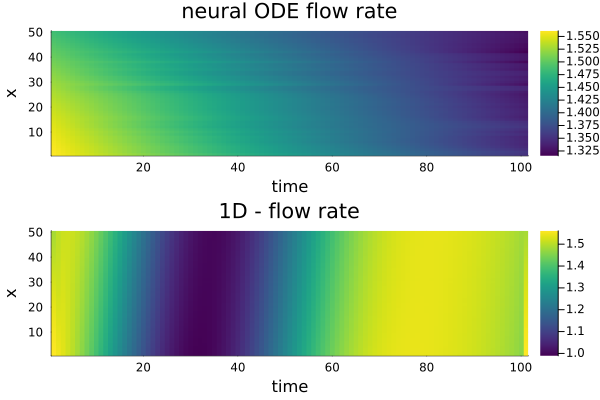

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-3.5371065
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 369.07570538411227
Iteration: 2 || Loss: 329.87000829147684
Iteration: 3 || Loss: 334.92633449376206
Iteration: 4 || Loss: 343.0318409208305
Iteration: 5 || Loss: 338.4324742591586
Iteration: 6 || Loss: 329.87000829147684
saving ADAM checkpoint...
Sum of params:-3.4767036
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 329.87000829147684
Iteration: 2 || Loss: 332.9640622833717
Iteration: 3 || Loss: 326.62631241189507
Iteration: 4 || Loss: 325.2689311304713
Iteration: 5 || Loss: 328.1167141724795
Iteration: 6 || Loss: 326.8388474884357
Iteration: 7 || Loss: 324.24570921276336
Iteration: 8 || Loss: 324.21622036007494
Iteration: 9 || Loss: 325.9707133488735
Iteration: 10 || Loss: 326.02695730118825
Iteration: 11 || Loss: 324.65645914497964
Iteration: 12 || Loss: 323.6650575262103
Iteratio

Iteration: 185 || Loss: 320.1106858889723
Iteration: 186 || Loss: 320.08800287816405
Iteration: 187 || Loss: 320.06527366796786
Iteration: 188 || Loss: 320.0424444939732
Iteration: 189 || Loss: 320.01959570442045
Iteration: 190 || Loss: 319.9966261362018
Iteration: 191 || Loss: 319.97363014502923
Iteration: 192 || Loss: 319.9504681934689
Iteration: 193 || Loss: 319.9272607679473
Iteration: 194 || Loss: 319.90401842703454
Iteration: 195 || Loss: 319.8806680488004
Iteration: 196 || Loss: 319.8572652494851
Iteration: 197 || Loss: 319.8338418824595
Iteration: 198 || Loss: 319.81024407492913
Iteration: 199 || Loss: 319.7866370971341
Iteration: 200 || Loss: 319.7629036572333
Iteration: 201 || Loss: 319.7391399042429
Iteration: 202 || Loss: 319.71522762129143
Iteration: 203 || Loss: 319.6913588716363
Iteration: 204 || Loss: 319.66732291167256
Iteration: 205 || Loss: 319.64325697626003
Iteration: 206 || Loss: 319.6190957662274
Iteration: 207 || Loss: 319.5948608036569
Iteration: 208 || Loss: 3

Iteration: 379 || Loss: 314.33470924918356
Iteration: 380 || Loss: 314.29518277001625
Iteration: 381 || Loss: 314.2556180027357
Iteration: 382 || Loss: 314.21602221541156
Iteration: 383 || Loss: 314.17657763190266
Iteration: 384 || Loss: 314.1373042328335
Iteration: 385 || Loss: 314.0989366733631
Iteration: 386 || Loss: 314.0620978789336
Iteration: 387 || Loss: 314.0287491582359
Iteration: 388 || Loss: 314.002036212057
Iteration: 389 || Loss: 313.9883888561063
Iteration: 390 || Loss: 313.9984425767186
Iteration: 391 || Loss: 314.047007716551
Iteration: 392 || Loss: 314.1390481980635
Iteration: 393 || Loss: 314.2367271525321
Iteration: 394 || Loss: 314.221737926194
Iteration: 395 || Loss: 314.0071059082084
Iteration: 396 || Loss: 313.72169115556676
Iteration: 397 || Loss: 313.6164744937873
Iteration: 398 || Loss: 313.71128851805685
Iteration: 399 || Loss: 313.7823633823363
Iteration: 400 || Loss: 313.6668762801262
Iteration: 401 || Loss: 313.47823689847957
Iteration: 402 || Loss: 313.42

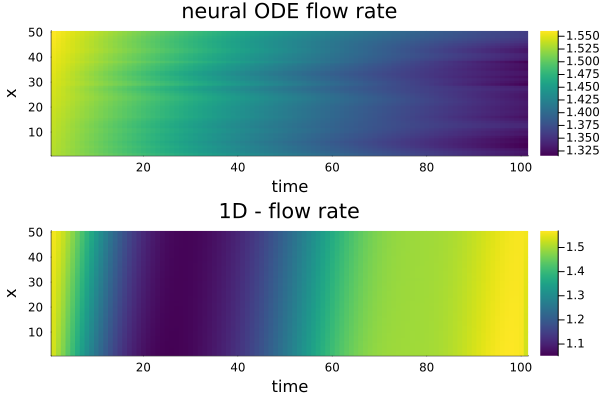

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-5.4005737
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 476.3149907202124
Iteration: 2 || Loss: 393.4700415389753
Iteration: 3 || Loss: 395.89346944005575
Iteration: 4 || Loss: 419.85018867520927
Iteration: 5 || Loss: 417.9561017002512
Iteration: 6 || Loss: 393.4700415389753
saving ADAM checkpoint...
Sum of params:-5.3697715
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 393.4700415389753
Iteration: 2 || Loss: 402.76169585132357
Iteration: 3 || Loss: 388.3573807857516
Iteration: 4 || Loss: 381.87039860856237
Iteration: 5 || Loss: 387.15384710963474
Iteration: 6 || Loss: 386.0850120578299
Iteration: 7 || Loss: 380.6649479793497
Iteration: 8 || Loss: 379.41863463594325
Iteration: 9 || Loss: 382.14093800870654
Iteration: 10 || Loss: 382.8617829030866
Iteration: 11 || Loss: 380.4103666961623
Iteration: 12 || Loss: 378.4064379086536
Iteration: 

Iteration: 186 || Loss: 368.4869131672177
Iteration: 187 || Loss: 368.43705331287407
Iteration: 188 || Loss: 368.3867351724008
Iteration: 189 || Loss: 368.3366716790822
Iteration: 190 || Loss: 368.28612304129746
Iteration: 191 || Loss: 368.2356455987683
Iteration: 192 || Loss: 368.1847902515398
Iteration: 193 || Loss: 368.13404701887407
Iteration: 194 || Loss: 368.0827020301371
Iteration: 195 || Loss: 368.0314820247569
Iteration: 196 || Loss: 367.9802704948573
Iteration: 197 || Loss: 367.92883355976875
Iteration: 198 || Loss: 367.8769645101175
Iteration: 199 || Loss: 367.8249500938194
Iteration: 200 || Loss: 367.77314178227533
Iteration: 201 || Loss: 367.72087029487733
Iteration: 202 || Loss: 367.6685311272677
Iteration: 203 || Loss: 367.61598107013543
Iteration: 204 || Loss: 367.563434857449
Iteration: 205 || Loss: 367.51048901842057
Iteration: 206 || Loss: 367.45749414920124
Iteration: 207 || Loss: 367.40433951426456
Iteration: 208 || Loss: 367.35109588025307
Iteration: 209 || Loss: 

Iteration: 380 || Loss: 355.4476633864514
Iteration: 381 || Loss: 355.3599954256045
Iteration: 382 || Loss: 355.2720933238959
Iteration: 383 || Loss: 355.18380989105566
Iteration: 384 || Loss: 355.0954552016724
Iteration: 385 || Loss: 355.0066911284797
Iteration: 386 || Loss: 354.9177916497188
Iteration: 387 || Loss: 354.828563621322
Iteration: 388 || Loss: 354.7388326803817
Iteration: 389 || Loss: 354.6491797553956
Iteration: 390 || Loss: 354.55912355657216
Iteration: 391 || Loss: 354.4689345159388
Iteration: 392 || Loss: 354.37833788367533
Iteration: 393 || Loss: 354.2876606259378
Iteration: 394 || Loss: 354.1966527298633
Iteration: 395 || Loss: 354.10514184315434
Iteration: 396 || Loss: 354.0135685937406
Iteration: 397 || Loss: 353.9217373817447
Iteration: 398 || Loss: 353.82973159118575
Iteration: 399 || Loss: 353.7373453666044
Iteration: 400 || Loss: 353.6447341369959
Iteration: 401 || Loss: 353.55176505084876
Iteration: 402 || Loss: 353.45866970170727
Iteration: 403 || Loss: 353.

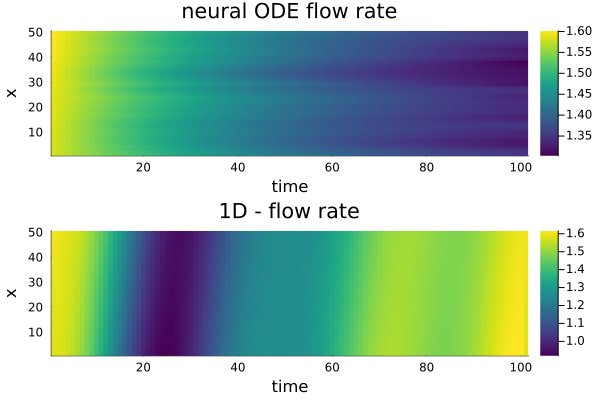

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-6.9984016
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 410.50589379474684
Iteration: 2 || Loss: 341.4268827016095
Iteration: 3 || Loss: 331.79572719693573
Iteration: 4 || Loss: 345.03729750873015
Iteration: 5 || Loss: 350.2462071961808
Iteration: 6 || Loss: 331.79572719693573
saving ADAM checkpoint...
Sum of params:-7.0497437
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 331.79572719693573
Iteration: 2 || Loss: 330.33114703796923
Iteration: 3 || Loss: 323.54648387483354
Iteration: 4 || Loss: 324.46170905368535
Iteration: 5 || Loss: 324.6111694476508
Iteration: 6 || Loss: 324.147957609257
Iteration: 7 || Loss: 323.85601106367204
Iteration: 8 || Loss: 323.2822400204827
Iteration: 9 || Loss: 322.9208145238254
Iteration: 10 || Loss: 322.44710507189654
Iteration: 11 || Loss: 321.6539391578082
Iteration: 12 || Loss: 321.29137179542937
Iteratio

Iteration: 186 || Loss: 307.33626527364515
Iteration: 187 || Loss: 307.23248671834835
Iteration: 188 || Loss: 307.12791953293987
Iteration: 189 || Loss: 307.0237254094378
Iteration: 190 || Loss: 306.91941280239746
Iteration: 191 || Loss: 306.81481354939075
Iteration: 192 || Loss: 306.7093406353949
Iteration: 193 || Loss: 306.60368065836093
Iteration: 194 || Loss: 306.49810471126955
Iteration: 195 || Loss: 306.3919262908973
Iteration: 196 || Loss: 306.28597082105296
Iteration: 197 || Loss: 306.1786304532282
Iteration: 198 || Loss: 306.0726135835998
Iteration: 199 || Loss: 305.9658383430088
Iteration: 200 || Loss: 305.8581944603081
Iteration: 201 || Loss: 305.75027173329426
Iteration: 202 || Loss: 305.6424373541452
Iteration: 203 || Loss: 305.53416133830945
Iteration: 204 || Loss: 305.4256360657659
Iteration: 205 || Loss: 305.31743605012394
Iteration: 206 || Loss: 305.20862671683614
Iteration: 207 || Loss: 305.09951499865105
Iteration: 208 || Loss: 304.98997301594466
Iteration: 209 || Lo

Iteration: 379 || Loss: 283.14055481064713
Iteration: 380 || Loss: 282.9996979768758
Iteration: 381 || Loss: 282.8589987667973
Iteration: 382 || Loss: 282.71716026686437
Iteration: 383 || Loss: 282.57618749542763
Iteration: 384 || Loss: 282.43473154907065
Iteration: 385 || Loss: 282.292940499198
Iteration: 386 || Loss: 282.1516554716819
Iteration: 387 || Loss: 282.00966421405866
Iteration: 388 || Loss: 281.8677630178164
Iteration: 389 || Loss: 281.7261660059176
Iteration: 390 || Loss: 281.58386657854953
Iteration: 391 || Loss: 281.4422531387198
Iteration: 392 || Loss: 281.2997718419773
Iteration: 393 || Loss: 281.15799955052273
Iteration: 394 || Loss: 281.0158187041311
Iteration: 395 || Loss: 280.8731667694633
Iteration: 396 || Loss: 280.73105146958966
Iteration: 397 || Loss: 280.5885000100591
Iteration: 398 || Loss: 280.44592236339207
Iteration: 399 || Loss: 280.3033899877668
Iteration: 400 || Loss: 280.16078690271183
Iteration: 401 || Loss: 280.0181382147708
Iteration: 402 || Loss: 2

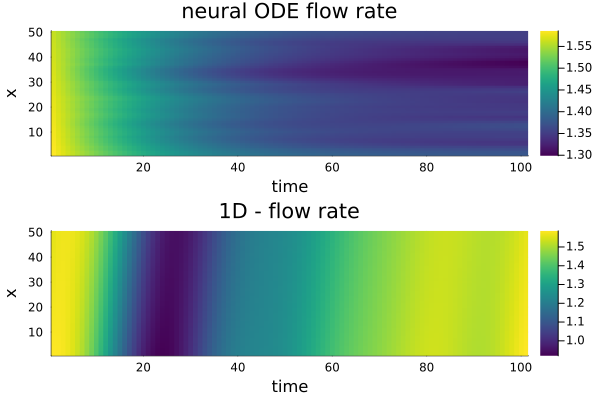

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-8.412964
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 339.85977986085135
Iteration: 2 || Loss: 328.32862954910377
Iteration: 3 || Loss: 327.5213246179282
Iteration: 4 || Loss: 323.5282911757552
Iteration: 5 || Loss: 321.0719099116164
Iteration: 6 || Loss: 321.0719099116164
saving ADAM checkpoint...
Sum of params:-8.398376
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 321.0719099116164
Iteration: 2 || Loss: 332.91229539111345
Iteration: 3 || Loss: 320.53623511939355
Iteration: 4 || Loss: 326.32565148423
Iteration: 5 || Loss: 324.20468965574116
Iteration: 6 || Loss: 319.1665085175155
Iteration: 7 || Loss: 319.91419322795537
Iteration: 8 || Loss: 321.8623450004321
Iteration: 9 || Loss: 320.317284845625
Iteration: 10 || Loss: 318.1643979824676
Iteration: 11 || Loss: 318.359755357197
Iteration: 12 || Loss: 319.24270893244153
Iteration: 13 || 

Iteration: 186 || Loss: 298.4470821327842
Iteration: 187 || Loss: 298.3230314604244
Iteration: 188 || Loss: 298.19927166473485
Iteration: 189 || Loss: 298.0749080401995
Iteration: 190 || Loss: 297.9504074431981
Iteration: 191 || Loss: 297.82603680915554
Iteration: 192 || Loss: 297.701329018808
Iteration: 193 || Loss: 297.5767814055408
Iteration: 194 || Loss: 297.45205600677843
Iteration: 195 || Loss: 297.32731361602845
Iteration: 196 || Loss: 297.2022990569997
Iteration: 197 || Loss: 297.07682460552445
Iteration: 198 || Loss: 296.9516763650636
Iteration: 199 || Loss: 296.8262436024711
Iteration: 200 || Loss: 296.70089067724706
Iteration: 201 || Loss: 296.57523938380206
Iteration: 202 || Loss: 296.44967206502344
Iteration: 203 || Loss: 296.3242246690034
Iteration: 204 || Loss: 296.19815854465185
Iteration: 205 || Loss: 296.07229104420736
Iteration: 206 || Loss: 295.94618666439976
Iteration: 207 || Loss: 295.8199945294123
Iteration: 208 || Loss: 295.6939072117075
Iteration: 209 || Loss: 

Iteration: 380 || Loss: 273.7111793269597
Iteration: 381 || Loss: 273.58572306886555
Iteration: 382 || Loss: 273.46152231621227
Iteration: 383 || Loss: 273.3369142302106
Iteration: 384 || Loss: 273.21352575267144
Iteration: 385 || Loss: 273.08909464393776
Iteration: 386 || Loss: 272.9646839414195
Iteration: 387 || Loss: 272.84034813790873
Iteration: 388 || Loss: 272.71692237911714
Iteration: 389 || Loss: 272.59259928654063
Iteration: 390 || Loss: 272.47022413978993
Iteration: 391 || Loss: 272.34364164410437
Iteration: 392 || Loss: 272.2220644620996
Iteration: 393 || Loss: 272.09846641143247
Iteration: 394 || Loss: 271.9736515073707
Iteration: 395 || Loss: 271.85030457972044
Iteration: 396 || Loss: 271.7267510238239
Iteration: 397 || Loss: 271.60360129550475
Iteration: 398 || Loss: 271.4800090190436
Iteration: 399 || Loss: 271.3585777162944
Iteration: 400 || Loss: 271.2375513061206
Iteration: 401 || Loss: 271.11173347772717
Iteration: 402 || Loss: 270.9880109180634
Iteration: 403 || Los

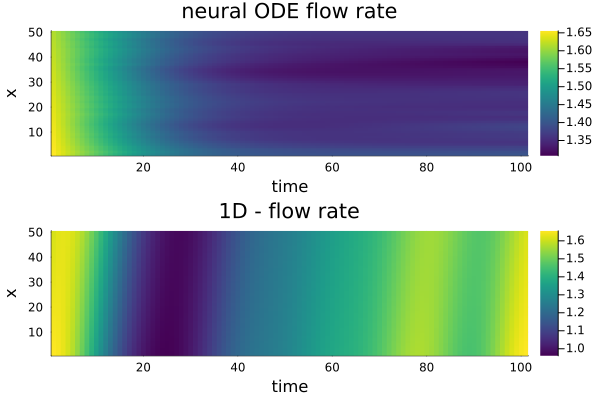

Epoch 2 mean loss loss:297.6134198317945
Start training epoch 3
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-9.620774
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 292.4779540943589
Iteration: 2 || Loss: 255.5301811649631
Iteration: 3 || Loss: 244.1412871639315
Iteration: 4 || Loss: 232.64592996489654
Iteration: 5 || Loss: 222.0111173381669
Iteration: 6 || Loss: 222.0111173381669
saving ADAM checkpoint...
Sum of params:-9.472096
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 222.0111173381669
Iteration: 2 || Loss: 221.62230762689228
Iteration: 3 || Loss: 216.30580154854295
Iteration: 4 || Loss: 214.05308008118817
Iteration: 5 || Loss: 211.7509673521621
Iteration: 6 || Loss: 213.4596651729891
Iteration: 7 || Loss: 213.61103202969338
Iteration: 8 || Loss: 210.92359214483116
Iteration: 9 || Loss: 209.7645393341325
Iteration: 10 || Loss: 211.1610281148959
Iteration: 11 || Loss: 211.52279114460384
Iteration: 12

Iteration: 183 || Loss: 202.8173727925993
Iteration: 184 || Loss: 202.78829363905552
Iteration: 185 || Loss: 202.7590899799532
Iteration: 186 || Loss: 202.72996028066225
Iteration: 187 || Loss: 202.70017321727292
Iteration: 188 || Loss: 202.67053205232756
Iteration: 189 || Loss: 202.6416364722928
Iteration: 190 || Loss: 202.61200667340765
Iteration: 191 || Loss: 202.5827910872157
Iteration: 192 || Loss: 202.55302582225082
Iteration: 193 || Loss: 202.52334437454385
Iteration: 194 || Loss: 202.49322250621495
Iteration: 195 || Loss: 202.46474232270492
Iteration: 196 || Loss: 202.43486543417498
Iteration: 197 || Loss: 202.40585354430974
Iteration: 198 || Loss: 202.37629054358797
Iteration: 199 || Loss: 202.34705308868087
Iteration: 200 || Loss: 202.3171956604907
Iteration: 201 || Loss: 202.28748436092408
Iteration: 202 || Loss: 202.2585222010888
Iteration: 203 || Loss: 202.22912570241573
Iteration: 204 || Loss: 202.19910269873736
Iteration: 205 || Loss: 202.16952505303158
Iteration: 206 ||

Iteration: 375 || Loss: 197.32065695817556
Iteration: 376 || Loss: 197.29368427383378
Iteration: 377 || Loss: 197.26658198918471
Iteration: 378 || Loss: 197.23793430779477
Iteration: 379 || Loss: 197.21348126214212
Iteration: 380 || Loss: 197.18574080740703
Iteration: 381 || Loss: 197.1579782365473
Iteration: 382 || Loss: 197.13252315445192
Iteration: 383 || Loss: 197.10509724650382
Iteration: 384 || Loss: 197.07967509255505
Iteration: 385 || Loss: 197.0522480207798
Iteration: 386 || Loss: 197.02620797937576
Iteration: 387 || Loss: 196.99948422024312
Iteration: 388 || Loss: 196.97112067003624
Iteration: 389 || Loss: 196.94327361911724
Iteration: 390 || Loss: 196.91807031925129
Iteration: 391 || Loss: 196.89043274279797
Iteration: 392 || Loss: 196.8664693399329
Iteration: 393 || Loss: 196.8403004333283
Iteration: 394 || Loss: 196.81363162239265
Iteration: 395 || Loss: 196.78675323929812
Iteration: 396 || Loss: 196.76029232277705
Iteration: 397 || Loss: 196.73245267016645
Iteration: 398 

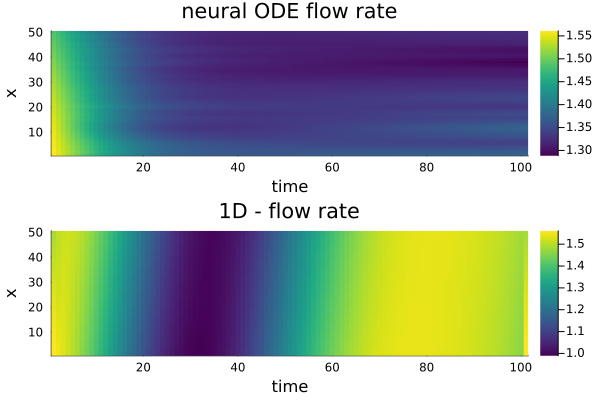

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-9.756496
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 236.26585852171758
Iteration: 2 || Loss: 201.2362265821372
Iteration: 3 || Loss: 199.09191045101832
Iteration: 4 || Loss: 199.3116722716564
Iteration: 5 || Loss: 195.22215654899998
Iteration: 6 || Loss: 195.22215654899998
saving ADAM checkpoint...
Sum of params:-9.76182
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 195.22215654899998
Iteration: 2 || Loss: 193.49573586229508
Iteration: 3 || Loss: 195.73831318112198
Iteration: 4 || Loss: 191.08295493258458
Iteration: 5 || Loss: 186.4638639190105
Iteration: 6 || Loss: 188.86010991037006
Iteration: 7 || Loss: 191.7040927991457
Iteration: 8 || Loss: 189.3950194548999
Iteration: 9 || Loss: 186.77518310048526
Iteration: 10 || Loss: 186.4777469450047
Iteration: 11 || Loss: 187.6002978687988
Iteration: 12 || Loss: 188.26832455353414
Iteration: 13 || Loss: 187.9079794726608
It

Iteration: 185 || Loss: 181.35200534281077
Iteration: 186 || Loss: 181.32015365315237
Iteration: 187 || Loss: 181.29470423196074
Iteration: 188 || Loss: 181.26420298861575
Iteration: 189 || Loss: 181.2275843829468
Iteration: 190 || Loss: 181.20704401113352
Iteration: 191 || Loss: 181.17785078030647
Iteration: 192 || Loss: 181.15212756145513
Iteration: 193 || Loss: 181.1223006980689
Iteration: 194 || Loss: 181.09312567456664
Iteration: 195 || Loss: 181.05523636405428
Iteration: 196 || Loss: 181.0365873761894
Iteration: 197 || Loss: 181.00820564853564
Iteration: 198 || Loss: 180.97403713997588
Iteration: 199 || Loss: 180.9525543179737
Iteration: 200 || Loss: 180.92285936596585
Iteration: 201 || Loss: 180.895049847941
Iteration: 202 || Loss: 180.86577208361774
Iteration: 203 || Loss: 180.8353956662864
Iteration: 204 || Loss: 180.80274702992944
Iteration: 205 || Loss: 180.77547780651145
Iteration: 206 || Loss: 180.75017425967997
Iteration: 207 || Loss: 180.72304296646948
Iteration: 208 || 

Iteration: 378 || Loss: 175.87753222481945
Iteration: 379 || Loss: 175.84977537491767
Iteration: 380 || Loss: 175.82226089003905
Iteration: 381 || Loss: 175.79217463449078
Iteration: 382 || Loss: 175.7661951525919
Iteration: 383 || Loss: 175.74036193340189
Iteration: 384 || Loss: 175.71236511847653
Iteration: 385 || Loss: 175.6854612725821
Iteration: 386 || Loss: 175.655681239743
Iteration: 387 || Loss: 175.6314538481405
Iteration: 388 || Loss: 175.60310571360844
Iteration: 389 || Loss: 175.57644548214782
Iteration: 390 || Loss: 175.5473745718172
Iteration: 391 || Loss: 175.5210624512455
Iteration: 392 || Loss: 175.49400772042782
Iteration: 393 || Loss: 175.46637701610067
Iteration: 394 || Loss: 175.43848654079557
Iteration: 395 || Loss: 175.41223143430537
Iteration: 396 || Loss: 175.38322809563883
Iteration: 397 || Loss: 175.357460239381
Iteration: 398 || Loss: 175.33041180920216
Iteration: 399 || Loss: 175.30095140034854
Iteration: 400 || Loss: 175.2746559279861
Iteration: 401 || Los

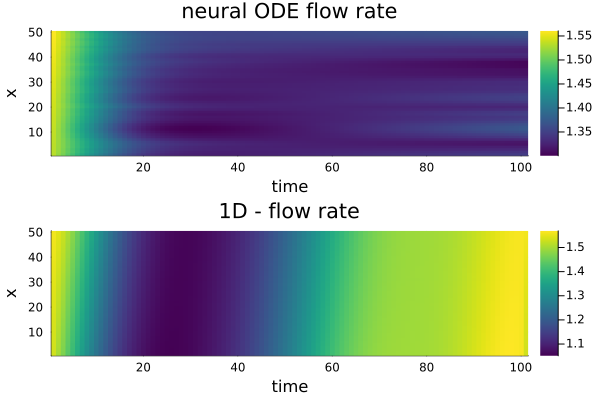

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-10.361004
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 292.7473069869511
Iteration: 2 || Loss: 220.12670076156098
Iteration: 3 || Loss: 219.85151351391465
Iteration: 4 || Loss: 239.28950189670027
Iteration: 5 || Loss: 239.5298065261513
Iteration: 6 || Loss: 219.85151351391465
saving ADAM checkpoint...
Sum of params:-10.309308
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 219.85151351391465
Iteration: 2 || Loss: 219.68378342421911
Iteration: 3 || Loss: 213.92210067029578
Iteration: 4 || Loss: 207.6609163771668
Iteration: 5 || Loss: 210.47776194816024
Iteration: 6 || Loss: 211.33374391444755
Iteration: 7 || Loss: 208.37023377107698
Iteration: 8 || Loss: 207.21672111130698
Iteration: 9 || Loss: 208.7911532974592
Iteration: 10 || Loss: 209.17433457824455
Iteration: 11 || Loss: 207.43128849035907
Iteration: 12 || Loss: 206.0601545653557
Iteration: 13 || Loss: 206.44947418046

Iteration: 185 || Loss: 201.71531764892532
Iteration: 186 || Loss: 201.69295455671076
Iteration: 187 || Loss: 201.6706502476383
Iteration: 188 || Loss: 201.64856567929365
Iteration: 189 || Loss: 201.62629669079493
Iteration: 190 || Loss: 201.6048120136084
Iteration: 191 || Loss: 201.58277264398836
Iteration: 192 || Loss: 201.5599285091899
Iteration: 193 || Loss: 201.5385258611389
Iteration: 194 || Loss: 201.51556810223587
Iteration: 195 || Loss: 201.49337635088483
Iteration: 196 || Loss: 201.4708707844818
Iteration: 197 || Loss: 201.44902913120177
Iteration: 198 || Loss: 201.42723108889612
Iteration: 199 || Loss: 201.40461854738007
Iteration: 200 || Loss: 201.38246631872585
Iteration: 201 || Loss: 201.36009280442323
Iteration: 202 || Loss: 201.33767530882827
Iteration: 203 || Loss: 201.31471804336817
Iteration: 204 || Loss: 201.29338603615687
Iteration: 205 || Loss: 201.27028761278535
Iteration: 206 || Loss: 201.2473241518553
Iteration: 207 || Loss: 201.22610435693798
Iteration: 208 ||

Iteration: 378 || Loss: 197.20021087398996
Iteration: 379 || Loss: 197.17680355802125
Iteration: 380 || Loss: 197.15222089229982
Iteration: 381 || Loss: 197.12696294113337
Iteration: 382 || Loss: 197.10334608583491
Iteration: 383 || Loss: 197.079294657019
Iteration: 384 || Loss: 197.05547711709724
Iteration: 385 || Loss: 197.03118375266618
Iteration: 386 || Loss: 197.00675661955992
Iteration: 387 || Loss: 196.9827969233342
Iteration: 388 || Loss: 196.95753869606008
Iteration: 389 || Loss: 196.9336291604033
Iteration: 390 || Loss: 196.90935922332233
Iteration: 391 || Loss: 196.88557420896484
Iteration: 392 || Loss: 196.8619164792898
Iteration: 393 || Loss: 196.83696529386182
Iteration: 394 || Loss: 196.81273069560376
Iteration: 395 || Loss: 196.78800300235042
Iteration: 396 || Loss: 196.76482312702825
Iteration: 397 || Loss: 196.74056691517063
Iteration: 398 || Loss: 196.715880698659
Iteration: 399 || Loss: 196.69171674717902
Iteration: 400 || Loss: 196.66778551127825
Iteration: 401 || 

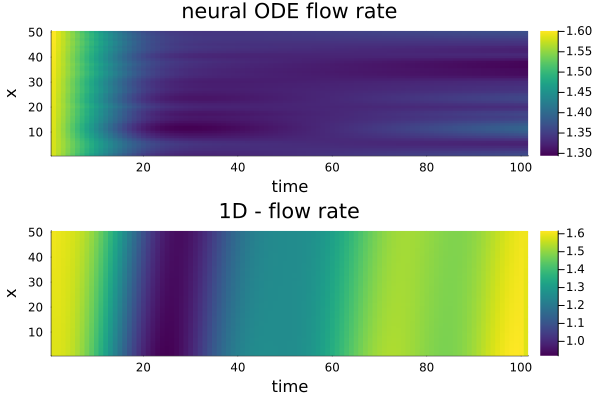

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-11.18858
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 290.22897346889704
Iteration: 2 || Loss: 211.7936034630995
Iteration: 3 || Loss: 192.7083650458334
Iteration: 4 || Loss: 205.5967606698858
Iteration: 5 || Loss: 216.9558748062148
Iteration: 6 || Loss: 192.7083650458334
saving ADAM checkpoint...
Sum of params:-11.235857
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 192.7083650458334
Iteration: 2 || Loss: 186.7450869108011
Iteration: 3 || Loss: 188.04709896301776
Iteration: 4 || Loss: 187.49504761136774
Iteration: 5 || Loss: 188.45442550175474
Iteration: 6 || Loss: 185.80487365404673
Iteration: 7 || Loss: 186.3384044138371
Iteration: 8 || Loss: 185.9586554567441
Iteration: 9 || Loss: 184.1801591384166
Iteration: 10 || Loss: 184.51459357631464
Iteration: 11 || Loss: 185.47571472333905
Iteration: 12 || Loss: 185.00450662304522
Iteration: 13 || Loss: 184.7364637777679
Ite

Iteration: 185 || Loss: 181.3808312968881
Iteration: 186 || Loss: 181.3643399610825
Iteration: 187 || Loss: 181.34543437288963
Iteration: 188 || Loss: 181.3260267911918
Iteration: 189 || Loss: 181.3085094776262
Iteration: 190 || Loss: 181.29105397306122
Iteration: 191 || Loss: 181.27080212727418
Iteration: 192 || Loss: 181.25357237265445
Iteration: 193 || Loss: 181.23564098933048
Iteration: 194 || Loss: 181.21774000149637
Iteration: 195 || Loss: 181.19747768729405
Iteration: 196 || Loss: 181.1800726430412
Iteration: 197 || Loss: 181.1617681659316
Iteration: 198 || Loss: 181.14123884343618
Iteration: 199 || Loss: 181.12437076058703
Iteration: 200 || Loss: 181.10590691348665
Iteration: 201 || Loss: 181.08658018637823
Iteration: 202 || Loss: 181.06771349182284
Iteration: 203 || Loss: 181.04956231280707
Iteration: 204 || Loss: 181.03002544387158
Iteration: 205 || Loss: 181.01264094101217
Iteration: 206 || Loss: 180.99266711611313
Iteration: 207 || Loss: 180.9734006107438
Iteration: 208 || 

Iteration: 378 || Loss: 177.35653200093682
Iteration: 379 || Loss: 177.33129133884034
Iteration: 380 || Loss: 177.30826889633713
Iteration: 381 || Loss: 177.28424492363217
Iteration: 382 || Loss: 177.25941727727087
Iteration: 383 || Loss: 177.23643749292756
Iteration: 384 || Loss: 177.2128859134057
Iteration: 385 || Loss: 177.19070227240945
Iteration: 386 || Loss: 177.16510937745397
Iteration: 387 || Loss: 177.14205823605096
Iteration: 388 || Loss: 177.1178390853652
Iteration: 389 || Loss: 177.09231889129106
Iteration: 390 || Loss: 177.06940065346757
Iteration: 391 || Loss: 177.0455917461849
Iteration: 392 || Loss: 177.0215592479882
Iteration: 393 || Loss: 176.9986785910621
Iteration: 394 || Loss: 176.97198380218418
Iteration: 395 || Loss: 176.94881196749245
Iteration: 396 || Loss: 176.92647190274596
Iteration: 397 || Loss: 176.9018800626842
Iteration: 398 || Loss: 176.87703897533282
Iteration: 399 || Loss: 176.85066113928772
Iteration: 400 || Loss: 176.8283392507468
Iteration: 401 || 

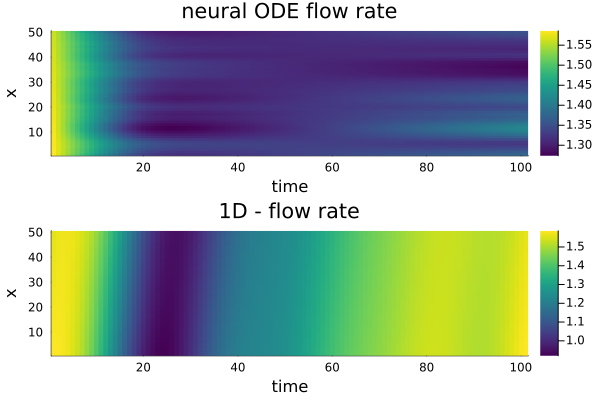

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-11.997513
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 215.73949128262757
Iteration: 2 || Loss: 204.45010647735648
Iteration: 3 || Loss: 203.93047799339018
Iteration: 4 || Loss: 200.21952876562216
Iteration: 5 || Loss: 196.1095254686015
Iteration: 6 || Loss: 196.1095254686015
saving ADAM checkpoint...
Sum of params:-11.951334
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 196.1095254686015
Iteration: 2 || Loss: 212.31630763877374
Iteration: 3 || Loss: 194.88727279030473
Iteration: 4 || Loss: 199.32820946303835
Iteration: 5 || Loss: 203.14757292515603
Iteration: 6 || Loss: 197.23177788189255
Iteration: 7 || Loss: 192.46932212603113
Iteration: 8 || Loss: 194.28927019585342
Iteration: 9 || Loss: 197.4976865327665
Iteration: 10 || Loss: 196.53318404961402
Iteration: 11 || Loss: 193.12556191869595
Iteration: 12 || Loss: 191.53254636212938
Iteration: 13 || Loss: 192.9229958786

Iteration: 185 || Loss: 188.25726470591118
Iteration: 186 || Loss: 188.22918388782455
Iteration: 187 || Loss: 188.21056009627316
Iteration: 188 || Loss: 188.18806359400588
Iteration: 189 || Loss: 188.16925201470218
Iteration: 190 || Loss: 188.14776100434727
Iteration: 191 || Loss: 188.12703183871113
Iteration: 192 || Loss: 188.1027005249813
Iteration: 193 || Loss: 188.08157540750295
Iteration: 194 || Loss: 188.06552480612928
Iteration: 195 || Loss: 188.04227187700994
Iteration: 196 || Loss: 188.02363685282904
Iteration: 197 || Loss: 187.99940735944077
Iteration: 198 || Loss: 187.9781466786107
Iteration: 199 || Loss: 187.95339119005416
Iteration: 200 || Loss: 187.9294361995289
Iteration: 201 || Loss: 187.9136165923981
Iteration: 202 || Loss: 187.8881550303256
Iteration: 203 || Loss: 187.866813887205
Iteration: 204 || Loss: 187.84506095862608
Iteration: 205 || Loss: 187.82187679823508
Iteration: 206 || Loss: 187.8007209295939
Iteration: 207 || Loss: 187.77907450468513
Iteration: 208 || L

Iteration: 377 || Loss: 183.47719909200987
Iteration: 378 || Loss: 183.44635990795837
Iteration: 379 || Loss: 183.41850040900115
Iteration: 380 || Loss: 183.39086857118807
Iteration: 381 || Loss: 183.35805790065208
Iteration: 382 || Loss: 183.33310555815802
Iteration: 383 || Loss: 183.29969364443397
Iteration: 384 || Loss: 183.27139437156285
Iteration: 385 || Loss: 183.24470921269724
Iteration: 386 || Loss: 183.21506245847152
Iteration: 387 || Loss: 183.18562388390535
Iteration: 388 || Loss: 183.15809462056717
Iteration: 389 || Loss: 183.12666637331196
Iteration: 390 || Loss: 183.1003266601021
Iteration: 391 || Loss: 183.06863134665275
Iteration: 392 || Loss: 183.04143937101105
Iteration: 393 || Loss: 183.01147871454864
Iteration: 394 || Loss: 182.984842939191
Iteration: 395 || Loss: 182.95184497770788
Iteration: 396 || Loss: 182.92681786760323
Iteration: 397 || Loss: 182.89401030172303
Iteration: 398 || Loss: 182.86476503773682
Iteration: 399 || Loss: 182.83734549322742
Iteration: 400

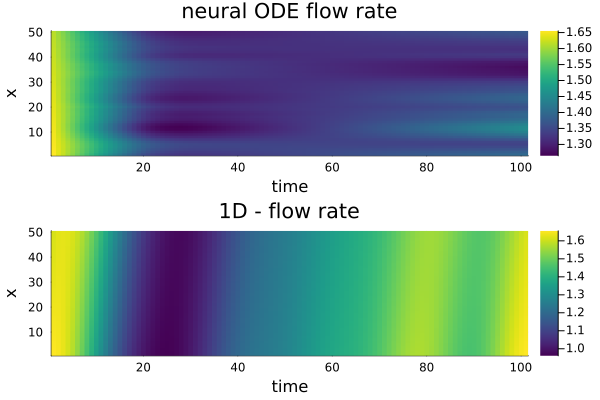

Epoch 3 mean loss loss:182.9644569950839
Start training epoch 4
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-12.681101
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 253.9722807558847
Iteration: 2 || Loss: 218.4333362266145
Iteration: 3 || Loss: 207.94446316185554
Iteration: 4 || Loss: 197.49278347157633
Iteration: 5 || Loss: 188.5762753100361
Iteration: 6 || Loss: 188.5762753100361
saving ADAM checkpoint...
Sum of params:-12.541108
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 188.5762753100361
Iteration: 2 || Loss: 182.94029443548814
Iteration: 3 || Loss: 181.54393838860585
Iteration: 4 || Loss: 175.4316553404068
Iteration: 5 || Loss: 176.29596113759158
Iteration: 6 || Loss: 177.54062114772907
Iteration: 7 || Loss: 177.32367027220897
Iteration: 8 || Loss: 175.83263926415088
Iteration: 9 || Loss: 175.26065923902416
Iteration: 10 || Loss: 175.99938111757407
Iteration: 11 || Loss: 175.72062544382064
Iterati

Iteration: 183 || Loss: 168.34679443551246
Iteration: 184 || Loss: 168.31658480963713
Iteration: 185 || Loss: 168.28591825411144
Iteration: 186 || Loss: 168.25560568819037
Iteration: 187 || Loss: 168.2252073006271
Iteration: 188 || Loss: 168.19414045668668
Iteration: 189 || Loss: 168.16370565641645
Iteration: 190 || Loss: 168.13317452514792
Iteration: 191 || Loss: 168.10215139054574
Iteration: 192 || Loss: 168.0713232750328
Iteration: 193 || Loss: 168.0402534930362
Iteration: 194 || Loss: 168.00896509337485
Iteration: 195 || Loss: 167.97800210538406
Iteration: 196 || Loss: 167.9475983653709
Iteration: 197 || Loss: 167.91567813276575
Iteration: 198 || Loss: 167.8846894309568
Iteration: 199 || Loss: 167.85338511231026
Iteration: 200 || Loss: 167.82210861898133
Iteration: 201 || Loss: 167.7907468923894
Iteration: 202 || Loss: 167.7590483205664
Iteration: 203 || Loss: 167.727213744751
Iteration: 204 || Loss: 167.69511094171412
Iteration: 205 || Loss: 167.66334030598213
Iteration: 206 || Lo

Iteration: 375 || Loss: 160.7162780034276
Iteration: 376 || Loss: 160.6632650843656
Iteration: 377 || Loss: 160.6096990268848
Iteration: 378 || Loss: 160.55658792541533
Iteration: 379 || Loss: 160.50281492258412
Iteration: 380 || Loss: 160.4486352009722
Iteration: 381 || Loss: 160.39482647012815
Iteration: 382 || Loss: 160.3404506473515
Iteration: 383 || Loss: 160.28598636575842
Iteration: 384 || Loss: 160.23125349931126
Iteration: 385 || Loss: 160.1763970610621
Iteration: 386 || Loss: 160.12121598730533
Iteration: 387 || Loss: 160.06627280071467
Iteration: 388 || Loss: 160.0108155921687
Iteration: 389 || Loss: 159.95512845724429
Iteration: 390 || Loss: 159.89920102032045
Iteration: 391 || Loss: 159.8432132463806
Iteration: 392 || Loss: 159.78683014039012
Iteration: 393 || Loss: 159.73040857475902
Iteration: 394 || Loss: 159.67395272251943
Iteration: 395 || Loss: 159.61714213284964
Iteration: 396 || Loss: 159.56004123479303
Iteration: 397 || Loss: 159.50268304959184
Iteration: 398 || L

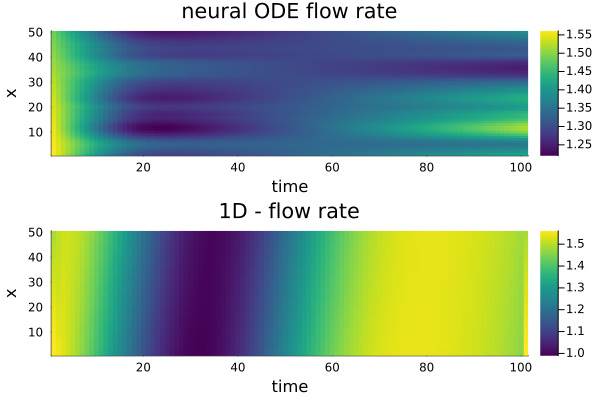

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-12.339575
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 185.71585050297853
Iteration: 2 || Loss: 154.4890348861371
Iteration: 3 || Loss: 151.27217642515515
Iteration: 4 || Loss: 150.34714881911526
Iteration: 5 || Loss: 146.19493481069625
Iteration: 6 || Loss: 146.19493481069625
saving ADAM checkpoint...
Sum of params:-12.34132
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 146.19493481069625
Iteration: 2 || Loss: 139.60873693093743
Iteration: 3 || Loss: 141.77479119396014
Iteration: 4 || Loss: 136.73137789763672
Iteration: 5 || Loss: 134.348940594468
Iteration: 6 || Loss: 136.32220087093336
Iteration: 7 || Loss: 137.33348520960877
Iteration: 8 || Loss: 135.6691246520912
Iteration: 9 || Loss: 134.08650075504428
Iteration: 10 || Loss: 134.38331546005475
Iteration: 11 || Loss: 135.39185410117847
Iteration: 12 || Loss: 135.29559056244184
Iteration: 13 || Loss: 134.21792757674

Iteration: 185 || Loss: 124.84119015222566
Iteration: 186 || Loss: 124.77255901906598
Iteration: 187 || Loss: 124.7039511144063
Iteration: 188 || Loss: 124.63472123858062
Iteration: 189 || Loss: 124.56541979230975
Iteration: 190 || Loss: 124.49589213525094
Iteration: 191 || Loss: 124.4256703275252
Iteration: 192 || Loss: 124.35607435162322
Iteration: 193 || Loss: 124.28578494355237
Iteration: 194 || Loss: 124.21522673581056
Iteration: 195 || Loss: 124.14452060650102
Iteration: 196 || Loss: 124.07415478288353
Iteration: 197 || Loss: 124.00266897132292
Iteration: 198 || Loss: 123.93128221021628
Iteration: 199 || Loss: 123.86007490250768
Iteration: 200 || Loss: 123.78823431750229
Iteration: 201 || Loss: 123.71663957767021
Iteration: 202 || Loss: 123.64414591329795
Iteration: 203 || Loss: 123.57181409240458
Iteration: 204 || Loss: 123.4990350058378
Iteration: 205 || Loss: 123.42580651214035
Iteration: 206 || Loss: 123.35241756968628
Iteration: 207 || Loss: 123.27972772918598
Iteration: 208

Iteration: 377 || Loss: 107.7166904602386
Iteration: 378 || Loss: 107.60892026015973
Iteration: 379 || Loss: 107.50153481481358
Iteration: 380 || Loss: 107.3937877883396
Iteration: 381 || Loss: 107.28564200977682
Iteration: 382 || Loss: 107.17779306941493
Iteration: 383 || Loss: 107.06953639996712
Iteration: 384 || Loss: 106.96136155033179
Iteration: 385 || Loss: 106.85294330254418
Iteration: 386 || Loss: 106.74461458032037
Iteration: 387 || Loss: 106.63556401806606
Iteration: 388 || Loss: 106.52673545112826
Iteration: 389 || Loss: 106.4183378688968
Iteration: 390 || Loss: 106.30926022475688
Iteration: 391 || Loss: 106.20004188490638
Iteration: 392 || Loss: 106.09079229766184
Iteration: 393 || Loss: 105.98142071433897
Iteration: 394 || Loss: 105.8720334318259
Iteration: 395 || Loss: 105.7624514085217
Iteration: 396 || Loss: 105.65288860046998
Iteration: 397 || Loss: 105.54306199909223
Iteration: 398 || Loss: 105.43334909200748
Iteration: 399 || Loss: 105.32329683652212
Iteration: 400 |

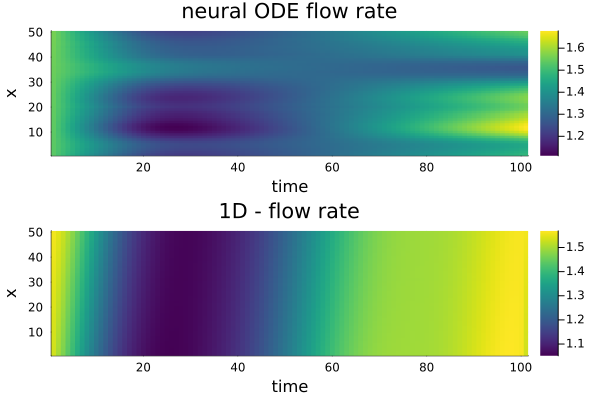

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-13.158883
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 174.31308738134788
Iteration: 2 || Loss: 129.1034534525813
Iteration: 3 || Loss: 129.5029253454559
Iteration: 4 || Loss: 140.62410709250761
Iteration: 5 || Loss: 140.29888545903523
Iteration: 6 || Loss: 129.1034534525813
saving ADAM checkpoint...
Sum of params:-13.130681
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 129.1034534525813
Iteration: 2 || Loss: 133.46324631939922
Iteration: 3 || Loss: 124.90053072145943
Iteration: 4 || Loss: 121.32289126077998
Iteration: 5 || Loss: 124.0479549486162
Iteration: 6 || Loss: 124.26824884279678
Iteration: 7 || Loss: 122.13108013942649
Iteration: 8 || Loss: 121.66480544440117
Iteration: 9 || Loss: 122.97421772406587
Iteration: 10 || Loss: 123.37090749022876
Iteration: 11 || Loss: 122.00775430890268
Iteration: 12 || Loss: 120.52727063184008
Iteration: 13 || Loss: 120.40652852562

Iteration: 184 || Loss: 110.37770715892441
Iteration: 185 || Loss: 110.31083129774318
Iteration: 186 || Loss: 110.24464993733159
Iteration: 187 || Loss: 110.17781336710702
Iteration: 188 || Loss: 110.11034530567814
Iteration: 189 || Loss: 110.04344902209996
Iteration: 190 || Loss: 109.97685088590978
Iteration: 191 || Loss: 109.90932120667689
Iteration: 192 || Loss: 109.84313835240901
Iteration: 193 || Loss: 109.77610137398926
Iteration: 194 || Loss: 109.70918103658096
Iteration: 195 || Loss: 109.64185974185939
Iteration: 196 || Loss: 109.57469591857394
Iteration: 197 || Loss: 109.50665337099282
Iteration: 198 || Loss: 109.43838576497029
Iteration: 199 || Loss: 109.371203787686
Iteration: 200 || Loss: 109.30388434873798
Iteration: 201 || Loss: 109.2364445614997
Iteration: 202 || Loss: 109.1681013082746
Iteration: 203 || Loss: 109.09994281316104
Iteration: 204 || Loss: 109.03143614452071
Iteration: 205 || Loss: 108.96438656724139
Iteration: 206 || Loss: 108.89634189375677
Iteration: 207 

Iteration: 377 || Loss: 96.56200533548102
Iteration: 378 || Loss: 96.48805084594991
Iteration: 379 || Loss: 96.41416987528169
Iteration: 380 || Loss: 96.3399510204001
Iteration: 381 || Loss: 96.26443280503888
Iteration: 382 || Loss: 96.19083555860615
Iteration: 383 || Loss: 96.11853625563485
Iteration: 384 || Loss: 96.04380268888285
Iteration: 385 || Loss: 95.97138383316673
Iteration: 386 || Loss: 95.8976219555863
Iteration: 387 || Loss: 95.8219540426074
Iteration: 388 || Loss: 95.74866604205893
Iteration: 389 || Loss: 95.67521235083946
Iteration: 390 || Loss: 95.60118161441258
Iteration: 391 || Loss: 95.52761570556564
Iteration: 392 || Loss: 95.45445512557338
Iteration: 393 || Loss: 95.38096554184519
Iteration: 394 || Loss: 95.30700561594827
Iteration: 395 || Loss: 95.23376238780513
Iteration: 396 || Loss: 95.15865839766275
Iteration: 397 || Loss: 95.0864417441343
Iteration: 398 || Loss: 95.01260388577094
Iteration: 399 || Loss: 94.93804883912803
Iteration: 400 || Loss: 94.86562890357

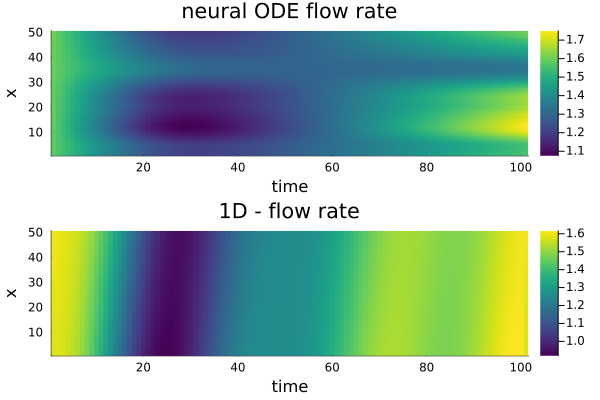

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-14.753366
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 168.8634873953027
Iteration: 2 || Loss: 111.81846091968241
Iteration: 3 || Loss: 90.3155756233322
Iteration: 4 || Loss: 92.76316064754144
Iteration: 5 || Loss: 101.41728360215053
Iteration: 6 || Loss: 90.3155756233322
saving ADAM checkpoint...
Sum of params:-14.845188
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 90.3155756233322
Iteration: 2 || Loss: 88.2012208837385
Iteration: 3 || Loss: 84.78626599827354
Iteration: 4 || Loss: 85.01874770965985
Iteration: 5 || Loss: 85.33593789741212
Iteration: 6 || Loss: 86.13265243548199
Iteration: 7 || Loss: 85.80157969828427
Iteration: 8 || Loss: 84.65458563522664
Iteration: 9 || Loss: 84.09615575399148
Iteration: 10 || Loss: 83.9051024620872
Iteration: 11 || Loss: 83.87635374308407
Iteration: 12 || Loss: 84.08605811199305
Iteration: 13 || Loss: 84.18021880248827
Iteration: 14

Iteration: 189 || Loss: 75.04974312842711
Iteration: 190 || Loss: 74.99052463557648
Iteration: 191 || Loss: 74.93937241876168
Iteration: 192 || Loss: 74.88309474204002
Iteration: 193 || Loss: 74.82875112634984
Iteration: 194 || Loss: 74.77255285256977
Iteration: 195 || Loss: 74.71507241335333
Iteration: 196 || Loss: 74.66240236724875
Iteration: 197 || Loss: 74.6063052712644
Iteration: 198 || Loss: 74.5509156834285
Iteration: 199 || Loss: 74.49430504494028
Iteration: 200 || Loss: 74.4391860040616
Iteration: 201 || Loss: 74.38117639661888
Iteration: 202 || Loss: 74.32802198947394
Iteration: 203 || Loss: 74.26973368201857
Iteration: 204 || Loss: 74.21452379454183
Iteration: 205 || Loss: 74.16236753333041
Iteration: 206 || Loss: 74.10646899267861
Iteration: 207 || Loss: 74.05071794122861
Iteration: 208 || Loss: 73.99408438904861
Iteration: 209 || Loss: 73.93761697483315
Iteration: 210 || Loss: 73.8817590789024
Iteration: 211 || Loss: 73.82755298838929
Iteration: 212 || Loss: 73.77201390877

Iteration: 385 || Loss: 64.25850061342778
Iteration: 386 || Loss: 64.21382827367925
Iteration: 387 || Loss: 64.0276836880205
Iteration: 388 || Loss: 64.07286765378672
Iteration: 389 || Loss: 64.10613307098951
Iteration: 390 || Loss: 63.93037862943736
Iteration: 391 || Loss: 63.844202060983804
Iteration: 392 || Loss: 63.86521893524447
Iteration: 393 || Loss: 63.76860090108414
Iteration: 394 || Loss: 63.666360605845114
Iteration: 395 || Loss: 63.65291900488537
Iteration: 396 || Loss: 63.608669000636276
Iteration: 397 || Loss: 63.52340080394048
Iteration: 398 || Loss: 63.475920108422336
Iteration: 399 || Loss: 63.45370832091994
Iteration: 400 || Loss: 63.3655329989293
Iteration: 401 || Loss: 63.31702017067452
Iteration: 402 || Loss: 63.28118551810352
Iteration: 403 || Loss: 63.20920986075501
Iteration: 404 || Loss: 63.14697810796961
Iteration: 405 || Loss: 63.08485046673895
Iteration: 406 || Loss: 63.02263889439054
Iteration: 407 || Loss: 62.99815687977481
Iteration: 408 || Loss: 62.94762

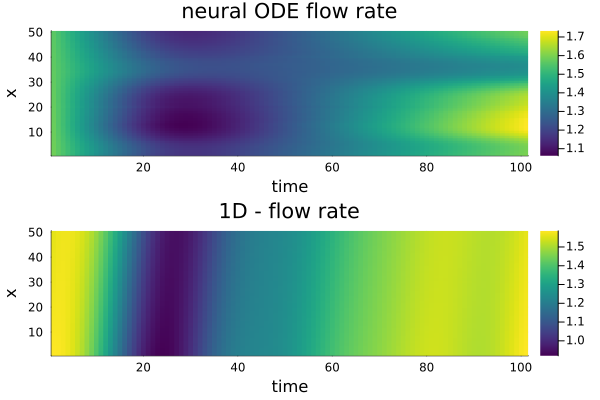

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-16.582333
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 153.8724907383559
Iteration: 2 || Loss: 116.87605192092298
Iteration: 3 || Loss: 90.88626305585159
Iteration: 4 || Loss: 77.06313023863498
Iteration: 5 || Loss: 73.50849620609539
Iteration: 6 || Loss: 73.50849620609539
saving ADAM checkpoint...
Sum of params:-16.322397
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 73.50849620609539
Iteration: 2 || Loss: 74.83019850949616
Iteration: 3 || Loss: 70.10911454380906
Iteration: 4 || Loss: 71.79746016907224
Iteration: 5 || Loss: 71.09605907341547
Iteration: 6 || Loss: 69.79473549032448
Iteration: 7 || Loss: 69.89929723044713
Iteration: 8 || Loss: 70.1658089958069
Iteration: 9 || Loss: 69.95473987835125
Iteration: 10 || Loss: 69.68699393728205
Iteration: 11 || Loss: 69.41154371973057
Iteration: 12 || Loss: 69.24862719385041
Iteration: 13 || Loss: 69.31018872120441
Iteration:

Iteration: 188 || Loss: 61.975882667775984
Iteration: 189 || Loss: 61.92478232694616
Iteration: 190 || Loss: 61.89058726732339
Iteration: 191 || Loss: 61.843610619662584
Iteration: 192 || Loss: 61.80248159085054
Iteration: 193 || Loss: 61.76205100960241
Iteration: 194 || Loss: 61.71450144863787
Iteration: 195 || Loss: 61.67469556937011
Iteration: 196 || Loss: 61.63042266422191
Iteration: 197 || Loss: 61.58623627793879
Iteration: 198 || Loss: 61.54520493817273
Iteration: 199 || Loss: 61.496973469654975
Iteration: 200 || Loss: 61.451752916050474
Iteration: 201 || Loss: 61.408399747278644
Iteration: 202 || Loss: 61.370938688149515
Iteration: 203 || Loss: 61.323658196996924
Iteration: 204 || Loss: 61.281965897090025
Iteration: 205 || Loss: 61.23856164986056
Iteration: 206 || Loss: 61.195864103867386
Iteration: 207 || Loss: 61.14981475495378
Iteration: 208 || Loss: 61.106082797736136
Iteration: 209 || Loss: 61.061661586279094
Iteration: 210 || Loss: 61.01854928161586
Iteration: 211 || Loss:

Iteration: 382 || Loss: 53.04827077600391
Iteration: 383 || Loss: 52.998507346968616
Iteration: 384 || Loss: 52.955212313529294
Iteration: 385 || Loss: 52.90512019616566
Iteration: 386 || Loss: 52.85801483856319
Iteration: 387 || Loss: 52.80590999330264
Iteration: 388 || Loss: 52.759311554853895
Iteration: 389 || Loss: 52.71252485340721
Iteration: 390 || Loss: 52.665205087516455
Iteration: 391 || Loss: 52.61703613023034
Iteration: 392 || Loss: 52.570893444805854
Iteration: 393 || Loss: 52.52311269463525
Iteration: 394 || Loss: 52.47116976385038
Iteration: 395 || Loss: 52.42879620564611
Iteration: 396 || Loss: 52.375096193173185
Iteration: 397 || Loss: 52.325307242237486
Iteration: 398 || Loss: 52.27411154082889
Iteration: 399 || Loss: 52.225056284031446
Iteration: 400 || Loss: 52.17714050428386
Iteration: 401 || Loss: 52.13306254474141
Iteration: 402 || Loss: 52.08442561526808
Iteration: 403 || Loss: 52.03570508306512
Iteration: 404 || Loss: 51.98703096018622
Iteration: 405 || Loss: 51

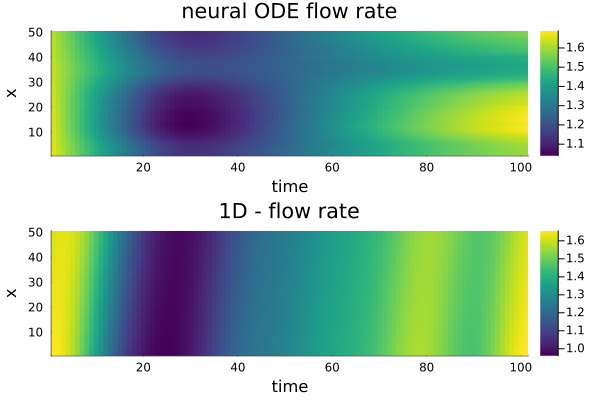

Epoch 4 mean loss loss:87.95463920457102
Start training epoch 5
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-17.718052
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 179.37320458292743
Iteration: 2 || Loss: 142.11726735026048
Iteration: 3 || Loss: 114.69647712769529
Iteration: 4 || Loss: 92.23639461441331
Iteration: 5 || Loss: 75.86276111039699
Iteration: 6 || Loss: 75.86276111039699
saving ADAM checkpoint...
Sum of params:-17.73166
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 75.86276111039699
Iteration: 2 || Loss: 65.22393273426118
Iteration: 3 || Loss: 60.66841017033893
Iteration: 4 || Loss: 59.04327086040131
Iteration: 5 || Loss: 57.36971298180205
Iteration: 6 || Loss: 56.305357070261245
Iteration: 7 || Loss: 55.08414756158176
Iteration: 8 || Loss: 54.18173717866897
Iteration: 9 || Loss: 54.20310695377311
Iteration: 10 || Loss: 54.699992919253496
Iteration: 11 || Loss: 55.12827166680118
Iteration: 12 

Iteration: 185 || Loss: 38.35721331539578
Iteration: 186 || Loss: 38.277765692017546
Iteration: 187 || Loss: 38.19877776096999
Iteration: 188 || Loss: 38.11760525783453
Iteration: 189 || Loss: 38.03840323563847
Iteration: 190 || Loss: 37.95783712709265
Iteration: 191 || Loss: 37.87696729712715
Iteration: 192 || Loss: 37.794882836572434
Iteration: 193 || Loss: 37.718689166983296
Iteration: 194 || Loss: 37.63817966726286
Iteration: 195 || Loss: 37.55672326767188
Iteration: 196 || Loss: 37.47966618715769
Iteration: 197 || Loss: 37.399969656535035
Iteration: 198 || Loss: 37.32133106672738
Iteration: 199 || Loss: 37.23878121345165
Iteration: 200 || Loss: 37.15978970963541
Iteration: 201 || Loss: 37.080062762349854
Iteration: 202 || Loss: 36.99838667414365
Iteration: 203 || Loss: 36.9227659947801
Iteration: 204 || Loss: 36.841125439185426
Iteration: 205 || Loss: 36.76180832915917
Iteration: 206 || Loss: 36.681201999951114
Iteration: 207 || Loss: 36.600955341257944
Iteration: 208 || Loss: 36.

Iteration: 378 || Loss: 24.829871559936766
Iteration: 379 || Loss: 24.775423488158534
Iteration: 380 || Loss: 24.722710569764452
Iteration: 381 || Loss: 24.672389053706798
Iteration: 382 || Loss: 24.61444241749888
Iteration: 383 || Loss: 24.563135351959485
Iteration: 384 || Loss: 24.51013288834517
Iteration: 385 || Loss: 24.4587701268102
Iteration: 386 || Loss: 24.405054632986626
Iteration: 387 || Loss: 24.35261172851223
Iteration: 388 || Loss: 24.30494897020737
Iteration: 389 || Loss: 24.254753415034262
Iteration: 390 || Loss: 24.20142784716446
Iteration: 391 || Loss: 24.149045635712334
Iteration: 392 || Loss: 24.097515632838455
Iteration: 393 || Loss: 24.04556447997403
Iteration: 394 || Loss: 23.99643562420353
Iteration: 395 || Loss: 23.944357727111793
Iteration: 396 || Loss: 23.89553496571325
Iteration: 397 || Loss: 23.84575915026365
Iteration: 398 || Loss: 23.79445446137149
Iteration: 399 || Loss: 23.751824221984233
Iteration: 400 || Loss: 23.69578661331817
Iteration: 401 || Loss: 

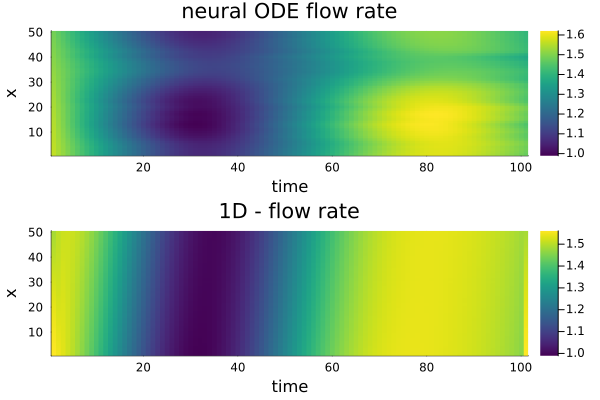

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-17.101711
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 134.38845227225713
Iteration: 2 || Loss: 89.21791988983739
Iteration: 3 || Loss: 61.50783489721547
Iteration: 4 || Loss: 44.90233902273239
Iteration: 5 || Loss: 38.66070919416499
Iteration: 6 || Loss: 38.66070919416499
saving ADAM checkpoint...
Sum of params:-16.94669
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 38.66070919416499
Iteration: 2 || Loss: 36.924436009171636
Iteration: 3 || Loss: 31.242010297035506
Iteration: 4 || Loss: 28.690637379529743
Iteration: 5 || Loss: 27.40363366224957
Iteration: 6 || Loss: 25.54680737684054
Iteration: 7 || Loss: 25.048203460259387
Iteration: 8 || Loss: 25.679110226522326
Iteration: 9 || Loss: 25.58365297338045
Iteration: 10 || Loss: 24.966442184937776
Iteration: 11 || Loss: 24.744699598658432
Iteration: 12 || Loss: 24.941915016346556
Iteration: 13 || Loss: 24.899214270731864
I

Iteration: 185 || Loss: 15.683581968722377
Iteration: 186 || Loss: 15.668092101832006
Iteration: 187 || Loss: 15.651329781318932
Iteration: 188 || Loss: 15.636069662796737
Iteration: 189 || Loss: 15.620109582684414
Iteration: 190 || Loss: 15.604601462604595
Iteration: 191 || Loss: 15.590467076384298
Iteration: 192 || Loss: 15.573669491388676
Iteration: 193 || Loss: 15.559751182448544
Iteration: 194 || Loss: 15.543086962821006
Iteration: 195 || Loss: 15.527814971207548
Iteration: 196 || Loss: 15.51280664234557
Iteration: 197 || Loss: 15.498766272211927
Iteration: 198 || Loss: 15.483330970573494
Iteration: 199 || Loss: 15.467521057673345
Iteration: 200 || Loss: 15.452582894701656
Iteration: 201 || Loss: 15.438025633080525
Iteration: 202 || Loss: 15.422719331479167
Iteration: 203 || Loss: 15.408014596929737
Iteration: 204 || Loss: 15.394219678214395
Iteration: 205 || Loss: 15.378293596317716
Iteration: 206 || Loss: 15.364025843473806
Iteration: 207 || Loss: 15.349925646901958
Iteration: 2

Iteration: 377 || Loss: 13.163914280819343
Iteration: 378 || Loss: 13.15106711136772
Iteration: 379 || Loss: 13.138967886404126
Iteration: 380 || Loss: 13.127945291867395
Iteration: 381 || Loss: 13.11588824699055
Iteration: 382 || Loss: 13.104398400139575
Iteration: 383 || Loss: 13.092593371994235
Iteration: 384 || Loss: 13.080905848602619
Iteration: 385 || Loss: 13.069704856410532
Iteration: 386 || Loss: 13.05777528532775
Iteration: 387 || Loss: 13.046933017338844
Iteration: 388 || Loss: 13.034560801482623
Iteration: 389 || Loss: 13.022739811459791
Iteration: 390 || Loss: 13.011700613444368
Iteration: 391 || Loss: 12.999880444387475
Iteration: 392 || Loss: 12.988048321752068
Iteration: 393 || Loss: 12.976643116609551
Iteration: 394 || Loss: 12.964793325177524
Iteration: 395 || Loss: 12.95375686938557
Iteration: 396 || Loss: 12.942170245569708
Iteration: 397 || Loss: 12.930679386612724
Iteration: 398 || Loss: 12.920081748767341
Iteration: 399 || Loss: 12.907833888125657
Iteration: 400 

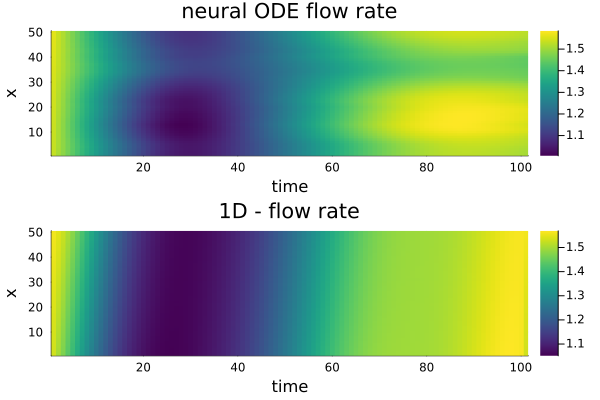

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-17.247305
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 85.71536173642849
Iteration: 2 || Loss: 49.47165562310904
Iteration: 3 || Loss: 40.34419544206259
Iteration: 4 || Loss: 42.48713946059365
Iteration: 5 || Loss: 44.50966903488497
Iteration: 6 || Loss: 40.34419544206259
saving ADAM checkpoint...
Sum of params:-17.199034
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 40.34419544206259
Iteration: 2 || Loss: 40.998741036866846
Iteration: 3 || Loss: 35.12868152711429
Iteration: 4 || Loss: 33.39516723667407
Iteration: 5 || Loss: 34.90429223175682
Iteration: 6 || Loss: 34.08192892875974
Iteration: 7 || Loss: 31.860243488953497
Iteration: 8 || Loss: 31.28183165949131
Iteration: 9 || Loss: 32.58842745623858
Iteration: 10 || Loss: 33.24143144091972
Iteration: 11 || Loss: 32.32740609603812
Iteration: 12 || Loss: 31.16027211505794
Iteration: 13 || Loss: 30.923575944392773
Iterati

Iteration: 185 || Loss: 27.734170079739442
Iteration: 186 || Loss: 27.728191452985644
Iteration: 187 || Loss: 27.716906097147625
Iteration: 188 || Loss: 27.70959582619799
Iteration: 189 || Loss: 27.699329706326722
Iteration: 190 || Loss: 27.688321253720154
Iteration: 191 || Loss: 27.672602119929593
Iteration: 192 || Loss: 27.670902644249413
Iteration: 193 || Loss: 27.658761038302252
Iteration: 194 || Loss: 27.651410147911967
Iteration: 195 || Loss: 27.64300912044488
Iteration: 196 || Loss: 27.629908602270834
Iteration: 197 || Loss: 27.62157197615613
Iteration: 198 || Loss: 27.61283626015837
Iteration: 199 || Loss: 27.603458158572366
Iteration: 200 || Loss: 27.59478847082073
Iteration: 201 || Loss: 27.585897256762976
Iteration: 202 || Loss: 27.57262002545512
Iteration: 203 || Loss: 27.566483558047835
Iteration: 204 || Loss: 27.557305847946484
Iteration: 205 || Loss: 27.543366838344763
Iteration: 206 || Loss: 27.535742816674954
Iteration: 207 || Loss: 27.526241553955025
Iteration: 208 ||

Iteration: 378 || Loss: 25.91647266399803
Iteration: 379 || Loss: 25.90739764802601
Iteration: 380 || Loss: 25.899011347765256
Iteration: 381 || Loss: 25.887342727496712
Iteration: 382 || Loss: 25.874228007364987
Iteration: 383 || Loss: 25.862709278034075
Iteration: 384 || Loss: 25.86157096352807
Iteration: 385 || Loss: 25.85078140764062
Iteration: 386 || Loss: 25.837857115729186
Iteration: 387 || Loss: 25.832711845046784
Iteration: 388 || Loss: 25.818934209423468
Iteration: 389 || Loss: 25.810668433296417
Iteration: 390 || Loss: 25.797648818971826
Iteration: 391 || Loss: 25.791465192759453
Iteration: 392 || Loss: 25.78274420615566
Iteration: 393 || Loss: 25.776054538556686
Iteration: 394 || Loss: 25.76596038296295
Iteration: 395 || Loss: 25.75436219546001
Iteration: 396 || Loss: 25.74455311951746
Iteration: 397 || Loss: 25.737230413215396
Iteration: 398 || Loss: 25.72667738615458
Iteration: 399 || Loss: 25.718322162943497
Iteration: 400 || Loss: 25.710707805612298
Iteration: 401 || Lo

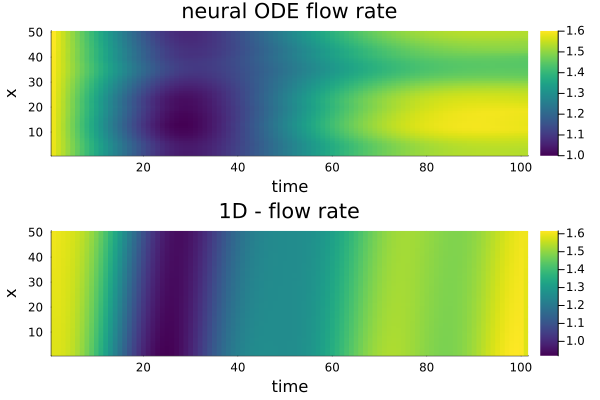

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-18.139917
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 113.0328638032076
Iteration: 2 || Loss: 51.93810176682459
Iteration: 3 || Loss: 28.459468283874426
Iteration: 4 || Loss: 28.50407062150357
Iteration: 5 || Loss: 37.68947874679266
Iteration: 6 || Loss: 28.459468283874426
saving ADAM checkpoint...
Sum of params:-18.265728
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 28.459468283874426
Iteration: 2 || Loss: 34.296692845541294
Iteration: 3 || Loss: 25.558843240742128
Iteration: 4 || Loss: 24.7972543198624
Iteration: 5 || Loss: 27.747703946229855
Iteration: 6 || Loss: 27.04991233481318
Iteration: 7 || Loss: 24.38826631632381
Iteration: 8 || Loss: 23.36259931908308
Iteration: 9 || Loss: 24.52415674041398
Iteration: 10 || Loss: 25.50590948582076
Iteration: 11 || Loss: 24.8543081888673
Iteration: 12 || Loss: 23.68568654701794
Iteration: 13 || Loss: 23.326088602298093
Itera

Iteration: 185 || Loss: 21.482436995442203
Iteration: 186 || Loss: 21.47673154999197
Iteration: 187 || Loss: 21.47150231935852
Iteration: 188 || Loss: 21.468774258470145
Iteration: 189 || Loss: 21.463291488830205
Iteration: 190 || Loss: 21.45625857231521
Iteration: 191 || Loss: 21.45171762649132
Iteration: 192 || Loss: 21.448440988648194
Iteration: 193 || Loss: 21.442909118324167
Iteration: 194 || Loss: 21.434315667116536
Iteration: 195 || Loss: 21.431581261391543
Iteration: 196 || Loss: 21.424635755652183
Iteration: 197 || Loss: 21.421460858156898
Iteration: 198 || Loss: 21.417796129196407
Iteration: 199 || Loss: 21.41132817337409
Iteration: 200 || Loss: 21.407339656110945
Iteration: 201 || Loss: 21.40254071145296
Iteration: 202 || Loss: 21.393379675766603
Iteration: 203 || Loss: 21.3912510592007
Iteration: 204 || Loss: 21.385974158486057
Iteration: 205 || Loss: 21.37916607270804
Iteration: 206 || Loss: 21.376404620395096
Iteration: 207 || Loss: 21.371871983590044
Iteration: 208 || Lo

Iteration: 378 || Loss: 20.452842452642376
Iteration: 379 || Loss: 20.444737217894602
Iteration: 380 || Loss: 20.44256092514639
Iteration: 381 || Loss: 20.43548257168229
Iteration: 382 || Loss: 20.430699930580055
Iteration: 383 || Loss: 20.42354139669122
Iteration: 384 || Loss: 20.419987759292376
Iteration: 385 || Loss: 20.41089391921596
Iteration: 386 || Loss: 20.40859684432459
Iteration: 387 || Loss: 20.40167761048286
Iteration: 388 || Loss: 20.398702279375076
Iteration: 389 || Loss: 20.39127347574044
Iteration: 390 || Loss: 20.385795963068272
Iteration: 391 || Loss: 20.381512315479938
Iteration: 392 || Loss: 20.37404129806865
Iteration: 393 || Loss: 20.370417067892426
Iteration: 394 || Loss: 20.364088325130027
Iteration: 395 || Loss: 20.35611163383966
Iteration: 396 || Loss: 20.350320201492192
Iteration: 397 || Loss: 20.34863813295309
Iteration: 398 || Loss: 20.34042434229341
Iteration: 399 || Loss: 20.33519096021233
Iteration: 400 || Loss: 20.331369954661376
Iteration: 401 || Loss:

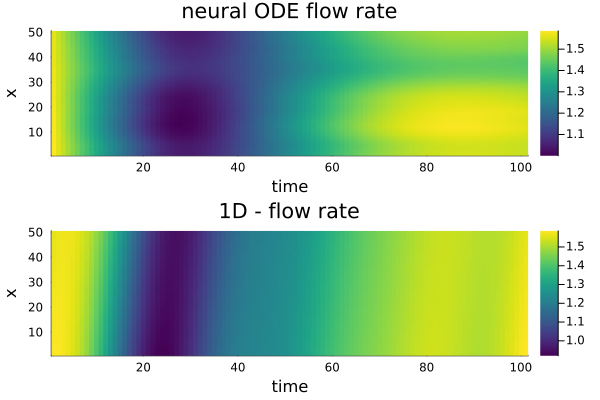

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-18.528652
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 100.20064664936044
Iteration: 2 || Loss: 59.22683711989295
Iteration: 3 || Loss: 37.45890689272552
Iteration: 4 || Loss: 32.40696468021156
Iteration: 5 || Loss: 35.82921908170049
Iteration: 6 || Loss: 32.40696468021156
saving ADAM checkpoint...
Sum of params:-18.370834
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 32.40696468021156
Iteration: 2 || Loss: 28.947447883416537
Iteration: 3 || Loss: 29.971893271671018
Iteration: 4 || Loss: 29.12305624677049
Iteration: 5 || Loss: 26.22085238978614
Iteration: 6 || Loss: 25.754086360246554
Iteration: 7 || Loss: 27.130930371953646
Iteration: 8 || Loss: 27.115543257155483
Iteration: 9 || Loss: 26.11457372901065
Iteration: 10 || Loss: 25.672208917706506
Iteration: 11 || Loss: 25.724975757951167
Iteration: 12 || Loss: 25.84435315278848
Iteration: 13 || Loss: 25.81865771860241
It

Excessive output truncated after 524324 bytes.

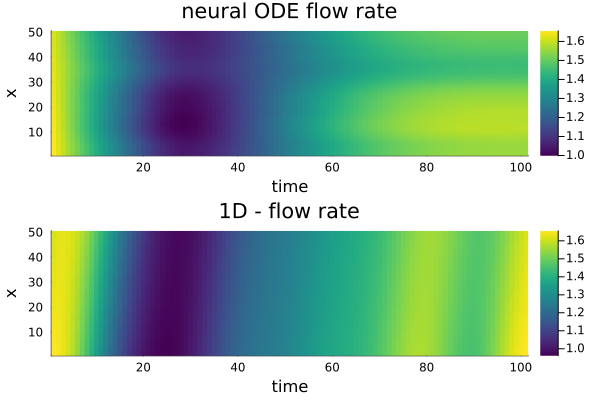

In [66]:

n_epochs = 5

#set time horizon settings
# nt = 100


list_loss_train = []
list_loss_epoch = []
# ntlist = [50,100]
ntlist = [100]
for nt in ntlist
    
    n_samples = Int(100/nt)+1
    println("nt:",nt)


    # epochs loop
    for j in 1:n_epochs
        println("Start training epoch ",j)
        loss_tot = 0.0
    
        # time horizon loop
        for k in 2:n_samples
            println("time: ",k-1, "/",n_samples-1)


            # loop over different waveforms
            for i in 1:size(ytrain2,3)
                
                println("waveform: ",i, "/",waveforms)
                
                
                
                T = dt * nt  # total time
                tspan = (0.0, T)
                println(tspan)
                tsteps = 0:dt:tspan[2]  # create time vector

                #define BC only on the time horizon that is active, zero otherwise
                bcflow_k = zero(bc_flow1)
                bcflow_k[(k-2)*nt+1:(k-1)*nt+1] = bc_flow[(k-2)*nt+1:(k-1)*nt+1,i]

                #define optimization problem
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);

                optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob),adtype) ;

                println("Using $optimizer_choice1 optimizer")
                println("Sum of params:", sum(uinit))

                # Change learning rate for ADAM optimizer, BFGS doesn't use it
                if j == 2
                    learning_rate = 0.0001
                    println("Changing learning rate to:",learning_rate)
                end

                uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
                println("Sum of params:", sum(uinit))

                if !isnothing(optimizer_choice2)
                    println("Switching to $optimizer_choice2 optimizer")

                    uinit = train_loop(uinit,adtype,optf,train_maxiters*100,learning_rate,optimizer_choice2)

                    println("Sum of params:", sum(uinit))

                end

                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t,bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);
                l , pred = loss(uinit,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob)
                loss_tot = loss_tot + l

                push!(list_loss_train, l)
                println("Epoch ", j, " loss:", l)
                print("dudx loss:",sum(abs2,∂x1 * pred - ∂x1 * ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]'))
                print("d2udx2 loss:",sum(abs2,∂x2 * pred - ∂x2 * ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]'))


                # plot solution for comparison
                plot1 = heatmap(pred[:,:], color=:viridis, title = "neural ODE flow rate")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap(ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]', title="1D - flow rate", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
            end
            
        end
    push!(list_loss_epoch, loss_tot/(size(ytrain2,3)*(n_samples-1)))
    println("Epoch ", j, " mean loss loss:", loss_tot/(size(ytrain2,3)*(n_samples-1)))
    end

    
end

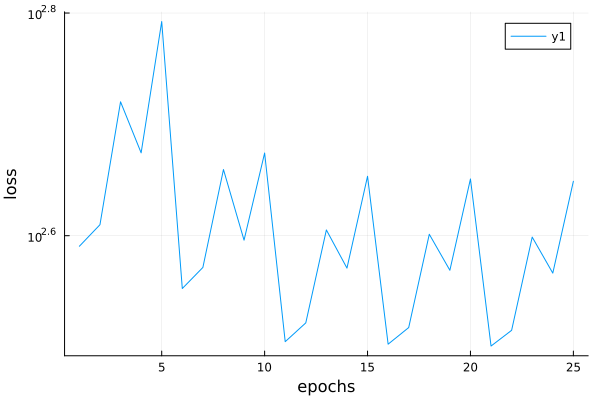

In [60]:
# plot loss as a function of epochs
p3 = plot(list_loss_train, yaxis=:log)
ylabel!("loss")
xlabel!("epochs")
png("parametric_BC_k_1DBlood_loss.png")
display(p3)

### Load the final learnt parameters and do inference ###

saved trained solution


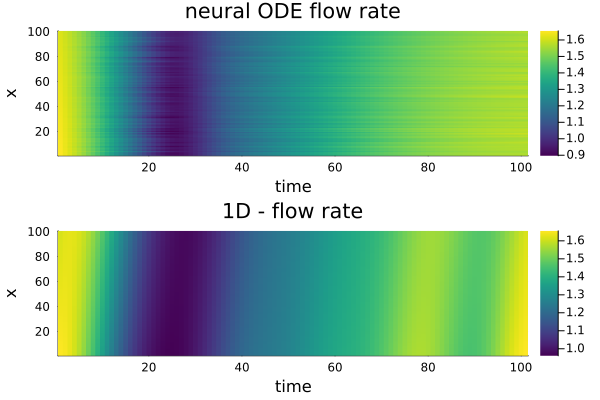

In [92]:
p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 5
u01 = u0[:,wv]

p = p_learn["p"]

T = 1                      # total time
tsteps = 0.0:dt:T             # discretized time dimension
tspan = (0,T)    

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

saved trained solution


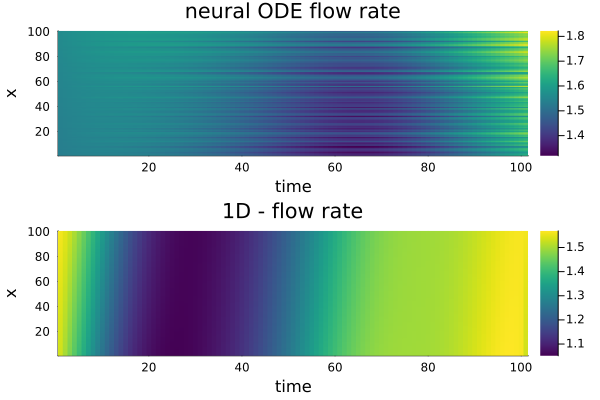

In [94]:
p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 2
u01 = u0[:,wv]

p = p_learn["p"]

T = 1                      # total time
tsteps = 0.0:dt:T             # discretized time dimension
tspan = (0,T)    

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [126]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

0.0:0.01:0.1

In [131]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

t:0.01
1512.8225980434204
saved trained solution
Loss: 1.3094590686431937
t:0.11
1499.0022035988716
saved trained solution
Loss: 45.88995970107579
t:0.21
1485.1817717310107
saved trained solution
Loss: 166.03289571339414
t:0.31
1471.3613010710685
saved trained solution
Loss: 201.69458180677182
t:0.41000000000000003
1457.5407821061353
saved trained solution
Loss: 100.65537789230933
t:0.51
1443.7202121595947
saved trained solution
Loss: 14.399602998020736
t:0.61
1429.8995878709964
saved trained solution
Loss: 5.772021530560427
t:0.71
1416.0789001858166
saved trained solution
Loss: 18.408064093324786
t:0.81
1402.2581533817172
saved trained solution
Loss: 21.566439159871727
t:0.91
1388.4373405339297
saved trained solution
Loss: 16.13946028735416


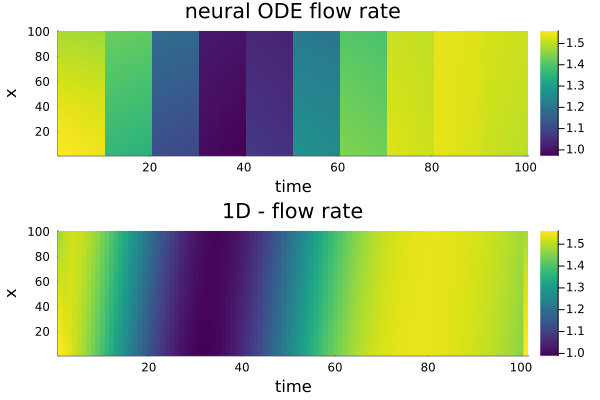

In [130]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))